In [3]:
# IMPORT PACKAGES
import geopandas as gpd
import osmnx as ox
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

from shapely.ops import nearest_points
from shapely.geometry import Point
from osmnx.features import features_from_place
from shapely.geometry import Point

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

from sqlalchemy import create_engine

import matplotlib.patches as mpatches

from itertools import chain

import seaborn as sns

import os

from shapely import wkt

import ast

from collections import defaultdict

import re

In [ ]:
# IMPORT THE BUILDING DATA

# 1. import building data from OSM

# 1.1 define place as the study area, in this case Zuidas, Amsterdam
place = ox.geocode_to_gdf("Zuidas, Amsterdam, Netherlands").to_crs(epsg=28992)
original_area = place  # still in EPSG:28992

# 1.2 define the buffer around the place, in this case set to 1000 meters
buffered_poly = place.geometry.iloc[0].buffer(1000)  # buffer in meters
buffered_poly_wgs = gpd.GeoSeries([buffered_poly], crs=28992).to_crs(epsg=4326).iloc[0]  # convert for OSMnx

# 1.3 get the buildings within the buffered area
building_tags = {"building": True}
osm_buildings = ox.features_from_polygon(buffered_poly_wgs, tags=building_tags).to_crs(epsg=28992)
osm_buildings['footprint_area'] = osm_buildings.geometry.area
osm_buildings = osm_buildings[['geometry', 'name', 'building', 'footprint_area']].copy()

# 1.4 get the amenities, public transport stops and parks within the buffered area
amenity_tags = ['bicycle_parking', 'parking', 'parking_space', 'motorcycle_parking',
                'cafe', 'restaurant', 'pub', 'bar', 'fast_food', 'food_court', 'ice_cream']
osm_amenities = ox.features_from_polygon(buffered_poly_wgs, tags={"amenity": amenity_tags}).to_crs(epsg=28992)
osm_amenities['footprint_area'] = osm_amenities.geometry.area
osm_amenities = osm_amenities[['geometry', 'amenity', 'footprint_area']].copy()

pt_tags = {'public_transport': ['platform'], 'railway': ['station', 'tram_stop'], 'station': ['subway']}
osm_pt = ox.features_from_polygon(buffered_poly_wgs, tags=pt_tags).to_crs(epsg=28992)

osm_pt['pt_type'] = osm_pt['station'].fillna(osm_pt['railway']).fillna(osm_pt['public_transport']) # Normalize PT types into one column
osm_pt = osm_pt[['geometry', 'pt_type']].copy()

platform_points = osm_pt[(osm_pt['pt_type'] == 'platform') & (osm_pt.geometry.type == 'Point')] # Filter: Keep stations + platform points only
other_pts = osm_pt[(osm_pt['pt_type'] != 'platform') | (osm_pt.geometry.type == 'Point')]
osm_pt = pd.concat([platform_points, other_pts]).drop_duplicates()

osm_parks = ox.features_from_polygon(buffered_poly_wgs, tags={'leisure': 'park'}).to_crs(epsg=28992)
osm_parks['origin_type'] = 'park'
osm_parks['footprint_area'] = osm_parks.geometry.area
osm_parks = osm_parks[['geometry', 'origin_type', 'footprint_area']].copy()

# 2. import building data from BAG

# 2.1 define the database connection, settings from TNO, and create the engine
user = "user"
password = "password"
host = "host"
port = "port"
database = "database"

engine = create_engine(f"postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}")

# 2.2 load obeject 'verblijfsobject' from the BAG database
sql_vbo = """
SELECT * 
FROM bag_2023_08.verblijfsobject 
WHERE ST_Within(
    wkb_geometry, 
    ST_Transform(
        ST_MakeEnvelope(4.831, 52.321, 4.917, 52.355, 4326),
        28992
    )
)
"""
vbo_raw = gpd.read_postgis(sql_vbo, engine, geom_col='wkb_geometry')

# 2.2.1 keep only the most recent verblijfsobject per identificatie
vbo = (
    vbo_raw
    .sort_values('tijdstipregistratie')
    .drop_duplicates(subset='identificatie', keep='last')
)

# 2.2.2 spatially filter VBOs that intersect with OSM buildings (takes only buildings in the study area, including the buffer)
vbo = gpd.sjoin(vbo, osm_buildings[['geometry']], how='inner', predicate='intersects')
vbo = vbo[vbo_raw.columns]  # drop sjoin metadata columns

# 2.2.3 keep only relevant columns
vbo = vbo[['ogc_fid', 'identificatie', 'gebruiksdoel', 'oppervlakte', 'wkb_geometry', 'pandref']].copy()

# 2.2.4 make string of list, some gebruiksdoelen have more than one entry per row
vbo['gebruiksdoel'] = vbo['gebruiksdoel'].apply(lambda x: ', '.join(x) if isinstance(x, list) else str(x))

# 2.3 load object 'pand' from the BAG database
sql_pand = """
SELECT * 
FROM bag_2023_08.pand 
WHERE ST_Within(
    wkb_geometry, 
    ST_Transform(
        ST_MakeEnvelope(4.831, 52.321, 4.917, 52.355, 4326),
        28992
    )
)
"""
pand_raw = gpd.read_postgis(sql_pand, engine, geom_col='wkb_geometry')

# 2.3.1 keep only the most recent pand per identificatie
pand = (
    pand_raw
    .sort_values('tijdstipregistratie')
    .drop_duplicates(subset='identificatie', keep='last')
)

# 2.3.2 spatially filter panden that intersect with OSM buildings
pand = gpd.sjoin(pand, osm_buildings[['geometry']], how='inner', predicate='intersects')
pand = pand[pand_raw.columns]  # drop sjoin metadata columns

# 3. combine OSM (amenities, pt and park) and BAG data

# 3.1 rename columns and aggregate amenity types 
vbo.rename(columns={'wkb_geometry': 'geometry', 'gebruiksdoel': 'origin_type', 'oppervlakte': 'GFA'}, inplace=True)
vbo = vbo.set_geometry('geometry')

osm_pt.rename(columns={'pt_type': 'origin_type'}, inplace=True)

osm_amenities.rename(columns={'amenity': 'origin_type'}, inplace=True)

horeca_types = ['cafe', 'restaurant', 'fast_food', 'ice_cream', 'bar', 'food_court', 'pub']
parking_types = ['parking', 'parking_space']

def remap_origin_type(x):
    if x in horeca_types:
        return 'horeca'
    elif x in parking_types:
        return 'parking'
    else:
        return x  # keep original if not in mapping
    
osm_amenities['origin_type'] = osm_amenities['origin_type'].apply(remap_origin_type)

# 3.2 combine all sources into one origins GeoDataFrame
building_info_bag = vbo.copy()  # has pandref
building_info_osm = pd.concat([osm_amenities, osm_pt, osm_parks], ignore_index=True)
building_info_osm['pandref'] = None  # explicitly set

building_info = pd.concat([building_info_bag, building_info_osm], ignore_index=True)

# 4. assign a single origin_type for multipurpose vbo's based on priority

# 4.1 Priority list 
priority_list = [
    'logiesfunctie', 
    'sportfunctie', 
    'kantoorfunctie', 
    'bijeenkomstfunctie', 
    'industriefunctie',
]
priority_map = {f: i for i, f in enumerate(priority_list)}

# 4.1 Manual overrides (exact matches)
manual_overrides = {
    "bijeenkomstfunctie, celfunctie, industriefunctie, kantoorfunctie, sportfunctie, overige gebruiksfunctie": "kantoorfunctie",
    "woonfunctie, kantoorfunctie": "woonfunctie",
}

def assign_highest_priority(origin_type):
    # First check manual overrides
    if origin_type in manual_overrides:
        return manual_overrides[origin_type]

    # Otherwise, use priority list
    if "," in origin_type:
        types = [t.strip() for t in origin_type.split(",")]
        for priority in priority_list:
            if priority in types:
                return priority
        return "overige gebruiksfunctie"  # fallback
    else:
        return origin_type

# 4.2 Apply transformation
building_info["origin_type"] = building_info["origin_type"].apply(assign_highest_priority)

# 5. Save geodataframe to file
output_folder = os.path.join("output", "building_data")
os.makedirs(output_folder, exist_ok=True)

# 5.1 Save combined building info
if "pandref" in building_info.columns:
    building_info["pandref"] = building_info["pandref"].apply(
        lambda x: ",".join(x) if isinstance(x, list) else (str(x) if pd.notnull(x) else None)
    )
building_info_path = os.path.join(output_folder, "building_info.geojson")
building_info.to_file(building_info_path, driver="GeoJSON")
print(f"Saved: {building_info_path}")

# 5.2 Save BAG pand separately
pand_path = os.path.join(output_folder, "bag_panden.geojson")
pand.to_file(pand_path, driver="GeoJSON")
print(f"Saved: {pand_path}")

# CHECK THE BUILDING DATA

# 1. print data overview

# 1.1 define a function to print the data overview
def save_dataset_overview(name, gdf, save_dir):
    file_path = os.path.join(save_dir, f"{name.replace(' ', '_').lower()}_overview.txt")
    if os.path.exists(file_path):
        print(f"Overview already exists: {file_path}")
        return

    # Convert lists to strings for summary stats
    gdf_copy = gdf.copy()
    for col in gdf_copy.columns:
        gdf_copy[col] = gdf_copy[col].apply(lambda x: ', '.join(map(str, x)) if isinstance(x, list) else x)

    with open(file_path, "w", encoding="utf-8") as f:
        f.write(f"{'='*60}\n")
        f.write(f"Dataset Overview: {name}\n")
        f.write(f"{'='*60}\n\n")
        f.write(f"➡ Shape (rows, columns):\n{gdf_copy.shape}\n\n")
        f.write(f"➡ Column names:\n{gdf_copy.columns.tolist()}\n\n")
        f.write("➡ Data types & non-null counts:\n")
        gdf_copy.info(buf=f)
        f.write("\n➡ Summary statistics (including categorical):\n")
        f.write(f"{gdf_copy.describe(include='all')}\n\n")
        f.write("➡ Unique values per column:\n")
        f.write(f"{gdf_copy.nunique()}\n\n")
        f.write("➡ Missing values per column:\n")
        f.write(f"{gdf_copy.isnull().sum()}\n\n")
        completeness = (gdf_copy.notnull().sum() / len(gdf_copy) * 100).round(1)
        f.write(f"➡ Completeness per column (%):\n{completeness}\n\n")
        # Dates
        date_cols = [col for col in gdf.columns if 'tijdstipregistratie' in col.lower()]
        for col in date_cols:
            f.write(f"Earliest date in {col}: {gdf[col].min()}\n")
            f.write(f"Latest date in {col}: {gdf[col].max()}\n")
    print(f"Overview saved to: {file_path}")
    
# 1.2 print the overview for each dataset
datasets = [
    ("OSM Buildings", osm_buildings),
    ("OSM Amenities", osm_amenities),
    ("OSM Public Transport", osm_pt),
    ("OSM Parks", osm_parks),
    ("BAG Verblijfsobjecten", vbo),
    ("BAG Panden", pand),
]

for name, gdf in datasets:
    save_dataset_overview(name, gdf, output_folder)

# 2.  plot OSM building data

# 2.1 define a function to plot the different OSM datasets
def plot_gdf(gdf, column, title, filename, cmap="tab20", base_gdf=None, extra_boundaries=None):
    file_path = os.path.join(output_folder, filename)
    if os.path.exists(file_path):
        print(f"Plot already exists: {file_path}")
        return

    fig, ax = plt.subplots(figsize=(10, 10))
    if base_gdf is not None:
        base_gdf.plot(ax=ax, color="lightgrey", edgecolor="black", linewidth=0.5, alpha=0.5)
    gdf.plot(ax=ax, column=column, categorical=True, legend=True,
             legend_kwds={"loc": "best", "fontsize": 8}, cmap=cmap, markersize=20)
    if extra_boundaries:
        for geom, style in extra_boundaries:
            gpd.GeoSeries([geom]).boundary.plot(ax=ax, **style)
    ax.set_title(title, fontsize=14)
    ax.set_axis_off()
    plt.tight_layout()
    plt.savefig(file_path, dpi=300, bbox_inches="tight")
    plt.close()
    print(f"Plot saved: {file_path}")

# 2.2 plot each OSM dataset using the defined function
plot_gdf(osm_buildings, "building", "OSM Buildings by Type", "osm_buildings.png")
plot_gdf(osm_amenities, "origin_type", "OSM Amenities by Type", "osm_amenities.png")
plot_gdf(osm_pt, "origin_type", "OSM Public Transport by Type", "osm_pt.png")
plot_gdf(osm_parks, "origin_type", "OSM Parks by Type", "osm_parks.png")


# 3. plot BAG building data

vbo_copy = vbo.copy()
vbo_copy["gebruiksdoel_cat"] = vbo_copy["origin_type"].apply(lambda x: "multipurpose" if isinstance(x, str) and "," in x else x)

unique_labels = sorted(vbo_copy["gebruiksdoel_cat"].dropna().unique())
label_to_idx = {label: i for i, label in enumerate(unique_labels)}
cmap = plt.get_cmap("tab20", len(unique_labels))

zuidas_poly = place.geometry.iloc[0]
buffered_poly = zuidas_poly.buffer(1000)

vbo_zuidas = vbo_copy[vbo_copy.geometry.within(zuidas_poly)].assign(color_idx=lambda df: df["gebruiksdoel_cat"].map(label_to_idx))
vbo_buffer = vbo_copy[vbo_copy.geometry.within(buffered_poly) & ~vbo_copy.geometry.within(zuidas_poly)].assign(color_idx=lambda df: df["gebruiksdoel_cat"].map(label_to_idx))

vbo_file = "vbo_zuidas_buffer.png"
if not os.path.exists(os.path.join(output_folder, vbo_file)):
    fig, ax = plt.subplots(figsize=(12, 12))
    pand.plot(ax=ax, color="lightgrey", edgecolor="black", linewidth=0.5)
    vbo_zuidas.plot(ax=ax, color=[cmap(i) for i in vbo_zuidas["color_idx"]], edgecolor="white", linewidth=0.2)
    vbo_buffer.plot(ax=ax, color=[cmap(i) for i in vbo_buffer["color_idx"]], edgecolor="white", linewidth=0.2, hatch="//")
    gpd.GeoSeries([zuidas_poly]).boundary.plot(ax=ax, color="black", linewidth=1.5, linestyle="--")
    gpd.GeoSeries([buffered_poly]).boundary.plot(ax=ax, color="red", linewidth=1.2, linestyle=":")
    legend_handles = [mpatches.Patch(color=cmap(i), label=label) for label, i in label_to_idx.items()]
    legend_handles += [mpatches.Patch(facecolor="none", edgecolor="black", linestyle="--", label="Zuidas boundary"),
                       mpatches.Patch(facecolor="none", edgecolor="red", linestyle=":", label="1km buffer")]
    ax.set_title("VBOs in Zuidas + 1km Buffer", fontsize=14)
    ax.axis("off")
    ax.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, vbo_file), dpi=300, bbox_inches="tight")
    plt.close()
    print(f"Plot saved: {os.path.join(output_folder, vbo_file)}")
else:
    print(f"Plot already exists: {os.path.join(output_folder, vbo_file)}")


# 4 plot the combined building data
# 4.1 create a copy of the building data and categorize usage types
building_data_copy = building_info.copy()
building_data_copy["origin_type_cat"] = building_data_copy["origin_type"].apply(
    lambda x: "multipurpose" if isinstance(x, str) and "," in x else x
)

# 4.2 plot the combined building data
all_building_file = os.path.join(output_folder, "buffer_building_types.png")
if not os.path.exists(all_building_file):
    unique_origins = sorted(building_data_copy['origin_type_cat'].dropna().unique())
    color_map = {ot: plt.cm.tab20(i % 20) for i, ot in enumerate(unique_origins)}

    fig, ax = plt.subplots(figsize=(15, 15))
    pand.plot(ax=ax, color='lightgrey', edgecolor='black', linewidth=0.5, alpha=0.5, zorder=1)

    for origin_type in unique_origins:
        subset = building_data_copy[building_data_copy['origin_type_cat'] == origin_type]
        subset.plot(ax=ax, color=color_map[origin_type], edgecolor='white', linewidth=0.2, zorder=2)

    zuidas_boundary = gpd.GeoSeries([place.geometry.iloc[0]]).boundary
    zuidas_boundary.plot(ax=ax, color='black', linewidth=2, linestyle='--', zorder=3)

    legend_patches = [mpatches.Patch(color=color_map[ot], label=ot) for ot in unique_origins]
    legend_patches.append(mpatches.Patch(facecolor='none', edgecolor='black', linestyle='--', label='Zuidas boundary'))
    ax.legend(handles=legend_patches, title="Building type", bbox_to_anchor=(1.05, 1), loc='upper left')

    ax.set_title("Building Types (BAG + OSM Amenities + PT Stops)", fontsize=14)
    ax.axis('off')
    plt.tight_layout()
    plt.savefig(all_building_file)
    plt.close(fig)
    print(f"Saved: {all_building_file}")
else:
    print(f"Skipped (already exists): {all_building_file}")

# 4.3 plot only within Zuidas
zuidas_file = os.path.join(output_folder, "zuidas_building_types.png")
if not os.path.exists(zuidas_file):
    building_data_zuidas = gpd.clip(building_data_copy, zuidas_poly)
    pand_zuidas = pand[pand.within(place.geometry.iloc[0])].copy()

    unique_origins_zuidas = sorted(building_data_zuidas['origin_type_cat'].dropna().unique())
    color_map_zuidas = {ot: plt.cm.tab20(i % 20) for i, ot in enumerate(unique_origins_zuidas)}

    fig, ax = plt.subplots(figsize=(15, 15))
    pand_zuidas.plot(ax=ax, color='lightgrey', edgecolor='black', linewidth=0.5, alpha=0.5, zorder=1)

    for origin_type in unique_origins_zuidas:
        subset = building_data_zuidas[building_data_zuidas['origin_type_cat'] == origin_type]
        subset.plot(ax=ax, color=color_map_zuidas[origin_type], edgecolor='white', linewidth=0.2, zorder=2)

    zuidas_boundary.plot(ax=ax, color='black', linewidth=2, linestyle='--', zorder=3)

    legend_patches = [mpatches.Patch(color=color_map_zuidas[ot], label=ot) for ot in unique_origins_zuidas]
    legend_patches.append(mpatches.Patch(facecolor='none', edgecolor='black', linestyle='--', label='Zuidas boundary'))
    ax.legend(handles=legend_patches, title="Building type", bbox_to_anchor=(1.05, 1), loc='upper left')

    ax.set_title("Building Types (Within Zuidas Only)", fontsize=14)
    ax.axis('off')
    plt.tight_layout()
    plt.savefig(zuidas_file)
    plt.close(fig)
    print(f"Saved: {zuidas_file}")
else:
    print(f"Skipped (already exists): {zuidas_file}")


In [84]:
# DETERMINE BUILDING WEIGHTS 

# 1. Load building data (with pandref & footprint_area)
building_info_file = os.path.join("output", "building_data", "building_info.geojson")
building_info = gpd.read_file(building_info_file).to_crs(epsg=28992)

# 2. Load parameters from Excel
param_file = os.path.join("input", "parameters_building_weights_different_weights.xlsx")
occupancy_df = pd.read_excel(param_file, sheet_name="occupancy_rates")
pt_freq_df   = pd.read_excel(param_file, sheet_name="pt_freq")

# 3. Assign station names manually
stations = building_info[building_info["origin_type"] == "station"].copy()
stations.loc[stations.index[1], "name"] = "Zuid"
stations.loc[stations.index[0], "name"] = "Rai"
building_info.loc[stations.index, "name"] = stations["name"]

# 4. Create occupancy mapping
per_gfa  = occupancy_df[occupancy_df['formula_type'] == 'per_gfa'].set_index('origin_type')['value'].to_dict()
per_area = occupancy_df[occupancy_df['formula_type'] == 'per_area'].set_index('origin_type')['value'].to_dict()
fixed    = occupancy_df[occupancy_df['formula_type'] == 'fixed'].set_index('origin_type')['value'].to_dict()

# 5. Compute building weights
def compute_weight(row):
    origin = row['origin_type']

    # per_gfa
    if origin in per_gfa:
        return row['GFA'] * per_gfa[origin]

    # per_area
    elif origin in per_area:
        return row['footprint_area'] * per_area[origin]

    # fixed
    elif origin in fixed:
        return fixed[origin]

    # fallback
    else:
        return 1  # default for "overige gebruiksfunctie"

building_info['weight'] = building_info.apply(compute_weight, axis=1)

# 6. Compute PT weights
def compute_pt_weight(stops, routes, freqs, buffer_size=10, fallback_to_mean=True):
    stops = stops.copy()
    routes = routes[routes.geometry.type.isin(['LineString', 'MultiLineString'])]
    stops['geometry'] = stops.geometry.buffer(buffer_size)
    
    joined = gpd.sjoin(stops, routes, how='left', predicate='intersects')
    
    if fallback_to_mean:
        default_freq = np.mean(list(freqs.values()))
    else:
        default_freq = 0  
    
    joined['nr_stops'] = joined['ref'].map(freqs).fillna(default_freq)
    
    joined = joined.reset_index()
    unique = joined[['index', 'ref', 'nr_stops']].drop_duplicates()
    weight_series = unique.groupby('index')['nr_stops'].sum()
    
    stops['weight'] = stops.index.map(weight_series).fillna(0).astype(int)
    return stops


tram_freqs = pt_freq_df[pt_freq_df['mode'] == 'tram'].set_index('line')['value'].to_dict()
tram_freqs = {str(k): v for k, v in tram_freqs.items()}
tram_stops = building_info[building_info['origin_type'] == 'tram_stop']
tram_routes = gpd.read_file("input/tram_lines.geojson").to_crs(epsg=28992)
tram_stops = compute_pt_weight(tram_stops, tram_routes, tram_freqs, fallback_to_mean=True)
building_info.loc[building_info['origin_type'] == 'tram_stop', 'weight'] = tram_stops['weight']

bus_freqs = pt_freq_df[pt_freq_df['mode'] == 'bus'].set_index('line')['value'].to_dict()
bus_freqs = {str(k): v for k, v in bus_freqs.items()}
bus_stops = building_info[building_info['origin_type'] == 'platform']
bus_routes = gpd.read_file("input/bus_lines.geojson").to_crs(epsg=28992)
bus_stops = compute_pt_weight(bus_stops, bus_routes, bus_freqs, fallback_to_mean=True)
building_info.loc[building_info['origin_type'] == 'platform', 'weight'] = bus_stops['weight']

subway_freqs = pt_freq_df[pt_freq_df['mode'] == 'subway'].set_index('line')['value'].to_dict()
subway_freqs = {str(k): v for k, v in subway_freqs.items()}
subway_stops = building_info[building_info['origin_type'] == 'subway']
subway_routes = gpd.read_file("input/subway_lines.geojson").to_crs(epsg=28992)
subway_stops = compute_pt_weight(subway_stops, subway_routes, subway_freqs, fallback_to_mean=True)
building_info.loc[building_info['origin_type'] == 'subway', 'weight'] = subway_stops['weight']

# 7. Assign station weights (from Excel)
station_weights = pt_freq_df[pt_freq_df['mode'] == 'station'].set_index('line')['value'].to_dict()
building_info.loc[building_info['origin_type'] == 'station', 'weight'] = building_info['name'].map(station_weights)

# 8. Clean up (keep all original columns)
if 'name' in building_info.columns:
    building_info = building_info.drop(columns=['name'])

# 9. Save final building_info with weights
output_folder = os.path.join("output", "building_data")
os.makedirs(output_folder, exist_ok=True)
output_path_weights = os.path.join(output_folder, "building_info_with_weights.geojson")
building_info.to_file(output_path_weights, driver="GeoJSON")

print(f"Saved final building info with weights to: {output_path_weights}")


Saved final building info with weights to: output\building_data\building_info_with_weights.geojson


In [85]:
#  CHECK THE BUILDING WEIGHTS

# 1. Load building data with weights and BAG pand, define output folder
output_folder = "output/building_data"
os.makedirs(output_folder, exist_ok=True)

building_info = gpd.read_file(os.path.join(output_folder, "building_info_with_weights.geojson")).to_crs(epsg=28992)

pand = gpd.read_file(os.path.join(output_folder, "bag_panden.geojson")).to_crs(epsg=28992)

place = ox.geocode_to_gdf("Zuidas, Amsterdam, Netherlands").to_crs(epsg=28992)
zuidas_poly = place.geometry.iloc[0]


# 2. print building_info with weights

# 2.1 save weights overview, list outliers and average weights per building type
output_txt = f"{output_folder}/building_info_weights_report.txt"

with open(output_txt, "w") as f:
    # --- 1. Building info head ---
    f.write("=== Building Info (first 15 rows) ===\n")
    f.write(building_info.head(15).to_string(index=False))
    f.write("\n\n")

    # --- 1.1 Outliers ---
    mean_w = building_info['weight'].mean()
    std_w = building_info['weight'].std()
    outliers = building_info[(building_info['weight'] > mean_w + 3*std_w) |
                             (building_info['weight'] < mean_w - 3*std_w)]
    f.write("=== Outliers (weights beyond 3 std devs) ===\n")
    if outliers.empty:
        f.write("No outliers found.\n")
    else:
        f.write(outliers[['identificatie', 'GFA', 'origin_type','weight']].to_string(index=False))
    f.write("\n\n")

    # --- 1.2 Average weight per building type ---
    avg_weights = building_info.groupby('origin_type')['weight'].mean().sort_values(ascending=False)
    f.write("=== Average Weight per Building Type ===\n")
    f.write(avg_weights.to_string())
    f.write("\n\n")

    # --- 1.3 Top 10 highest weights ---
    top10_weights = building_info[['origin_type','weight']].sort_values('weight', ascending=False).head(10)
    f.write("=== Top 10 Highest Weights ===\n")
    f.write(top10_weights.to_string(index=False))
    f.write("\n")

print(f"Saved building info report to {output_txt}")

# 2.2 plot the distribution of building weights
plt.figure(figsize=(10,6))
plt.hist(building_info['weight'], bins=50, color='skyblue', edgecolor='black', log=True)
plt.title('Distribution of Building Weights (logscale)')
plt.xlabel('Weight')
plt.ylabel('Number of Buildings')
plt.tight_layout()
plt.savefig(f"{output_folder}/building_weight_distribution.png", dpi=150)
plt.close()
print(f"Saved weight distribution plot to {output_folder}/building_weight_distribution.png")

# 3. plot building weights
output_folder = "output/building_data/original_weights"
os.makedirs(output_folder, exist_ok=True)

building_data_copy = building_info.copy()


building_data_copy = building_data_copy[building_data_copy.geometry.intersects(zuidas_poly)]
pand_data_copy = pand[pand.within(zuidas_poly)].copy()

unique_origins = sorted(building_data_copy['origin_type'].dropna().unique())
color_map = {ot: plt.cm.tab20(i % 20) for i, ot in enumerate(unique_origins)}

for otype in unique_origins:
    subset = building_data_copy[building_data_copy['origin_type'] == otype].copy()
    if subset.empty:
        print(f"No data for {otype}, skipping.")
        continue

    fig, ax = plt.subplots(figsize=(12, 12))

    # Base: all buildings
    pand_data_copy.plot(ax=ax, color='lightgrey', edgecolor='black', linewidth=0.5)

    # Special handling for woonfunctie and kantoorfunctie
    if otype in ['woonfunctie', 'kantoorfunctie']:
        subset['pandref_id'] = subset['pandref'].apply(
            lambda x: x[0] if isinstance(x, list) and x else (x if pd.notnull(x) else None)
        )
        agg = subset.groupby('pandref_id', dropna=False).agg({'weight': 'sum', 'geometry': 'first'}).reset_index()
        gdf_agg = gpd.GeoDataFrame(agg, geometry='geometry', crs=building_info.crs)


        color = 'orange' if otype == 'woonfunctie' else 'green'
        gdf_agg.plot(ax=ax, color=color, markersize=50, alpha=0.8)

        for idx, row in gdf_agg.iterrows():
            if pd.notnull(row['weight']):
                x, y = row.geometry.x, row.geometry.y
                ax.text(x, y, str(int(round(row['weight']))), fontsize=9,
                        ha='center', va='center', color='black', weight='bold')

        title_map = {
            'woonfunctie': "Woonfunctie (Residential) Origins: Weight Summed per Pand",
            'kantoorfunctie': "Kantoorfunctie (Office) Origins: Weight Summed per Pand"
        }
        ax.set_title(title_map[otype], fontsize=15)

    else:
        # Plot all other types as points
        subset.plot(ax=ax, color=color_map[otype], markersize=30, alpha=0.7)

        for idx, row in subset.iterrows():
            x, y = row.geometry.centroid.x, row.geometry.centroid.y
            weight = int(round(row['weight'])) if not pd.isnull(row['weight']) else 0
            ax.text(x, y, str(weight), fontsize=9, ha='right', va='bottom', color='darkred')

        ax.set_title(f"{otype.title()} Origins with Weights", fontsize=14)

    # Legend
    legend_items = [
        mpatches.Patch(color=color_map[otype], label=otype),
        mpatches.Patch(facecolor='none', edgecolor='black', linestyle='--', label='Zuidas boundary')
    ]
    ax.legend(handles=legend_items, loc='upper right')

    # Final plot tweaks
    ax.set_axis_off()
    plt.tight_layout()

    filename = f"{output_folder}/{otype}_weights.png"
    plt.savefig(filename, bbox_inches='tight', dpi=150)
    plt.close(fig)

    print(f"Saved figure for {otype} as {filename}")



Saved building info report to output/building_data/building_info_weights_report.txt
Saved weight distribution plot to output/building_data/building_weight_distribution.png
Saved figure for bicycle_parking as output/building_data/original_weights/bicycle_parking_weights.png
Saved figure for bijeenkomstfunctie as output/building_data/original_weights/bijeenkomstfunctie_weights.png
Saved figure for gezondheidszorgfunctie as output/building_data/original_weights/gezondheidszorgfunctie_weights.png
Saved figure for horeca as output/building_data/original_weights/horeca_weights.png
Saved figure for industriefunctie as output/building_data/original_weights/industriefunctie_weights.png
Saved figure for kantoorfunctie as output/building_data/original_weights/kantoorfunctie_weights.png
Saved figure for logiesfunctie as output/building_data/original_weights/logiesfunctie_weights.png
Saved figure for motorcycle_parking as output/building_data/original_weights/motorcycle_parking_weights.png
Saved fi

Saved building info with grouped types to: output\building_data\building_info_grouped_types.geojson


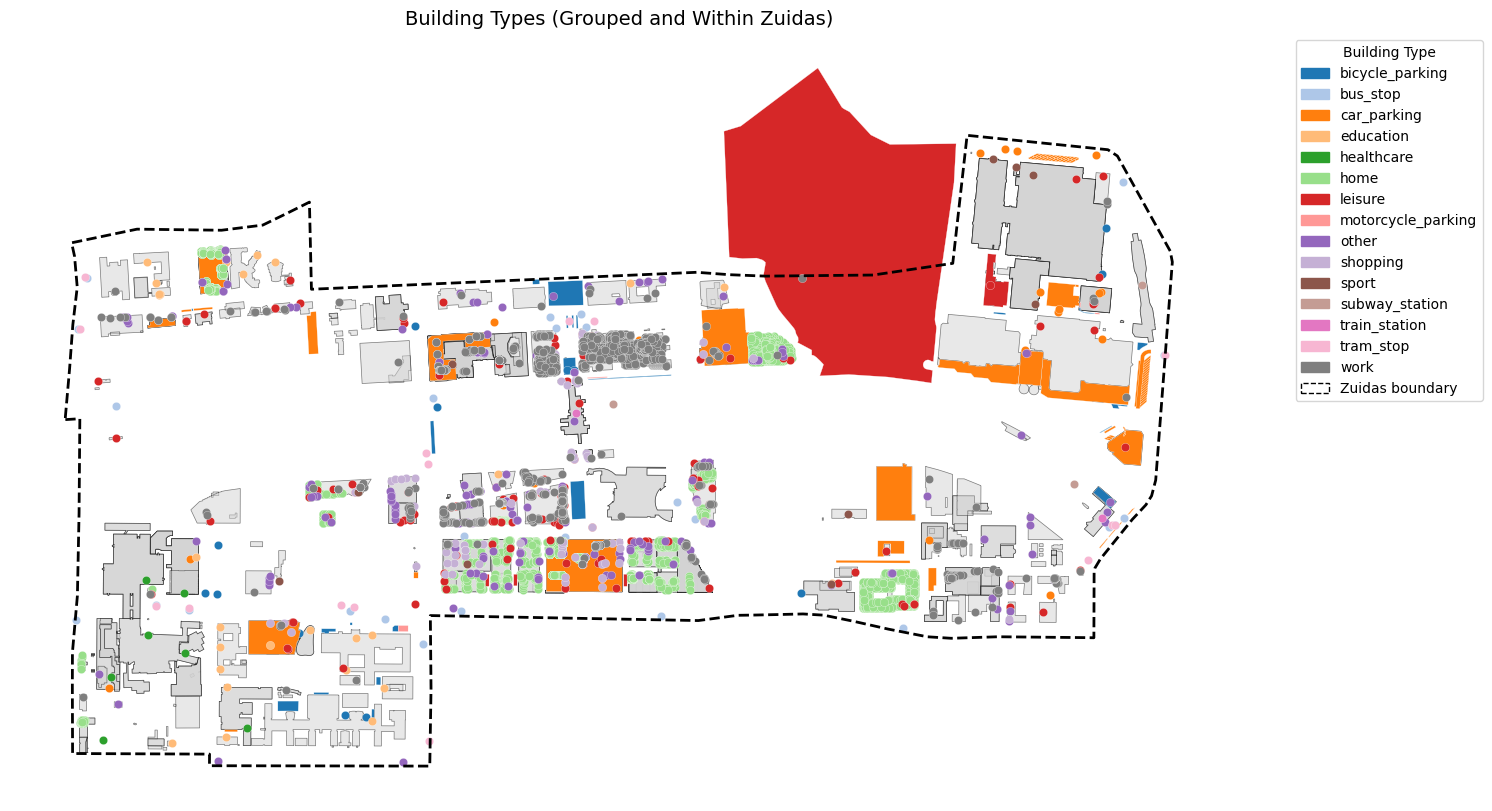

In [86]:
#  CHANGE THE ORIGIN AND DESTINATION TYPES TO MATCH THE TBD TRIP RATE ORIGIN AND DESTINATION COMBINATIONS

# 1. load building data
building_info = gpd.read_file(os.path.join("output", "building_data", "building_info_with_weights.geojson")).to_crs(epsg=28992)

# 1. define building type grouping
building_type_map = {
    'home': ['woonfunctie'],
    'work': ['kantoorfunctie', 'industriefunctie'],
    'education': ['onderwijsfunctie'],
    'shopping': ['winkelfunctie'],
    'leisure': ['bijeenkomstfunctie', 'horeca', 'park'],
    'sport': ['sportfunctie'],
    'healthcare': ['gezondheidszorgfunctie'],  
    'other': ['overige gebruiksfunctie'],
    'car_parking': ['parking'],
    'bicycle_parking': ['bicycle_parking'],
    'motorcycle_parking': ['motorcycle_parking'],
    'train_station': ['station'],
    'subway_station': ['subway'],
    'tram_stop': ['tram_stop'],
    'bus_stop': ['platform'],
}

# 2. create the reverse map from the original type to grouped type
function_to_grouped = {
    original: group
    for group, originals in building_type_map.items()
    for original in originals
}

# 3. define a function to map prigin_type to grouped type
def map_origin_type(origin):
    if not isinstance(origin, str) or not origin.strip():
        return None

    # Split on commas and strip spaces
    types = [t.strip() for t in origin.split(',')]
    grouped = []

    for t in types:
        group = function_to_grouped.get(t)
        if group:
            grouped.append(group)

    return ', '.join(sorted(set(grouped))) if grouped else None
    
# 4. apply the mapping to the building_info DataFrame
building_info['origin_type'] = building_info['origin_type'].apply(map_origin_type)

# 5. save the updated building_info
output_folder = os.path.join("output", "building_data")
os.makedirs(output_folder, exist_ok=True)           
output_path_grouped = os.path.join(output_folder, "building_info_grouped_types.geojson")
building_info.to_file(output_path_grouped, driver="GeoJSON")
print(f"Saved building info with grouped types to: {output_path_grouped}")

# 6. plot the updated building data with grouped origin types
pand = gpd.read_file(os.path.join(output_folder, "bag_panden.geojson")).to_crs(epsg=28992)

place = ox.geocode_to_gdf("Zuidas, Amsterdam, Netherlands").to_crs(epsg=28992)
zuidas_poly = place.geometry.iloc[0]

output_folder = "output/building_data"
os.makedirs(output_folder, exist_ok=True)  # create folder if it doesn't exist
output_file = os.path.join(output_folder, "final_building_types_zuidas.png")

building_data_copy = building_info[building_info.geometry.intersects(zuidas_poly)].copy()
pand_data_copy = pand[pand.within(zuidas_poly)].copy()

unique_origins = sorted(building_data_copy['origin_type'].dropna().unique())
color_map = {ot: plt.cm.tab20(i % 20) for i, ot in enumerate(unique_origins)}

fig, ax = plt.subplots(figsize=(15, 15))

# Base buildings
pand_data_copy.plot(ax=ax, color='lightgrey', edgecolor='black', linewidth=0.5, alpha=0.5, zorder=1)

# Overlay grouped origins
for ot in unique_origins:
    subset = building_data_copy[building_data_copy['origin_type'] == ot]
    subset.plot(ax=ax, color=color_map[ot], edgecolor='white', linewidth=0.2, zorder=2)

# Zuidas boundary
gpd.GeoSeries([zuidas_poly]).boundary.plot(ax=ax, color='black', linewidth=2, linestyle='--', zorder=3)

# Legend
legend_patches = [mpatches.Patch(color=color_map[ot], label=ot) for ot in unique_origins]
legend_patches.append(mpatches.Patch(facecolor='none', edgecolor='black', linestyle='--', label='Zuidas boundary'))
ax.legend(handles=legend_patches, title="Building Type", bbox_to_anchor=(1.05, 1), loc='upper left')

ax.set_title("Building Types (Grouped and Within Zuidas)", fontsize=14)
ax.axis('off')
plt.tight_layout()

# Save the figure
fig.savefig(output_file, dpi=300, bbox_inches='tight')
plt.show()


In [87]:
# IMPORT PEDESTRIAN NETWORK (ORIGINAL GRAPH)

# 1. Create buffered polygon in WGS84 for OSMnx query 
place = ox.geocode_to_gdf("Zuidas, Amsterdam, Netherlands").to_crs(epsg=28992)
buffered_poly = place.geometry.iloc[0].buffer(1000)  # buffer in meters
buffered_poly_wgs = gpd.GeoSeries([buffered_poly], crs=28992).to_crs(epsg=4326).iloc[0]  # convert for OSMnx

# 2. Get original pedestrian network using the buffered polygon
G_original = ox.graph_from_polygon(buffered_poly_wgs, network_type="walk", simplify=False)

# 3. Project original graph to EPSG:28992 to match other spatial data 
G_original_projected = ox.project_graph(G_original, to_crs="EPSG:28992")

# 4. Convert to GeoDataFrames
G_original_nodes, G_original_edges = ox.graph_to_gdfs(G_original_projected)

output_folder = os.path.join("output", "network")
os.makedirs(output_folder, exist_ok=True)

# 5 Save as GraphML
graphml_path_orig_proj = os.path.join(output_folder, "G_original_projected.graphml")
ox.save_graphml(G_original_projected, graphml_path_orig_proj)
print(f"Projected original graph saved as GraphML: {graphml_path_orig_proj}")

# INSERT THE BUILDING DATA INTO THE PEDESTRIAN NETWORK

# 1 ensure the building data is in the correct format
building_info = gpd.read_file(os.path.join("output", "building_data", "building_info_grouped_types.geojson"))
building_info = gpd.GeoDataFrame(building_info, geometry='geometry', crs=28992)

# 2 add a new column to store the centroid of each building
building_info['centroid'] = building_info.geometry.centroid

# 3 define function to find nearest point on the nearest edge
def get_nearest_edge_point(point, edges):
    distances = edges.geometry.distance(point)
    nearest_edge_uvkey = distances.idxmin()
    nearest_edge = edges.loc[nearest_edge_uvkey]
    nearest_point = nearest_points(point, nearest_edge.geometry)[1]
    return nearest_edge_uvkey, nearest_point

# 4 apply the function
building_info["nearest_edge_uvkey"], building_info["nearest_point"] = zip(
    *building_info.centroid.apply(lambda x: get_nearest_edge_point(x, G_original_edges))
)

# 5 create node id for each point and add these points to the original graph
max_orig_id = max(G_original_projected.nodes)  # 13077704198
building_info['node_id'] = range(max_orig_id + 1, max_orig_id + 1 + len(building_info))

G_projected = G_original_projected.copy()

for idx, row in building_info.iterrows():
    # Create a unique node ID (you could also use a string like f"od_{idx}")
    node_id = row['node_id']
    
    # Avoid re-adding a node if it's already present
    if node_id in G_projected.nodes:
        continue  # Skip this one
    
    # Get coordinates from the nearest_point (a shapely Point)
    x, y = row["nearest_point"].x, row["nearest_point"].y

    # Add node to the graph
    G_projected.add_node(node_id, x=x, y=y, geometry=row["nearest_point"], weight=row["weight"], origin_type=row["origin_type"])
    
# 6 define a distance function to calculate the distance between two nodes
def distance(node_a, node_b, graph):
    x1, y1 = graph.nodes[node_a]['x'], graph.nodes[node_a]['y']
    x2, y2 = graph.nodes[node_b]['x'], graph.nodes[node_b]['y']
    return Point(x1, y1).distance(Point(x2, y2))

# 7 insert the new nodes and edges into the graph, order based on the nearest edge and neighboring nodes on that edge

# 7.1 track which edges we've already processed
processed_edges = set()

# 7.2 determine neighboring origins for each origin on the same edge
building_info['neighboring_nodes'] = building_info['nearest_edge_uvkey'].apply(
    lambda node_edge_id: list(building_info[building_info['nearest_edge_uvkey'] == node_edge_id]['node_id'])
)

# 7.3 iterate through the snapped points and insert new nodes/edges
for idx, row in building_info.iterrows():
    u, v, k = row['nearest_edge_uvkey']
    node_id = row["node_id"]
    snapped_point = row["nearest_point"]
    edge_id = (u, v, k)
    neighbors = row['neighboring_nodes']

    # Avoid re-processing the same edge
    if edge_id in processed_edges:
        continue
    processed_edges.add(edge_id)

    if len(neighbors) == 1:
        # Directly connect new node between u and v
        if not G_projected.has_edge(u, node_id):
            G_projected.add_edge(u, node_id, key=0, length=distance(u, node_id, G_projected))
        if not G_projected.has_edge(node_id, v):
            G_projected.add_edge(node_id, v, key=0, length=distance(node_id, v, G_projected))

        if G_projected.has_edge(u, v, k):
            G_projected.remove_edge(u, v, k)

    else:
        # Multiple new nodes on same edge — create sorted chain
        chain_start = u
        chain_end = v
        edge_length = distance(u, v, G_projected)

        chain_nodes = [chain_start] + neighbors + [chain_end]
        chain_distances = [distance(v, node, G_projected) for node in neighbors]
        full_distances = [0] + chain_distances + [edge_length]

        sorted_indices = np.argsort(full_distances)
        sorted_chain_nodes = np.array(chain_nodes)[sorted_indices]
        sorted_distances = np.array(full_distances)[sorted_indices]

        for seq in range(len(sorted_chain_nodes) - 1):
            u_chain, v_chain = sorted_chain_nodes[seq], sorted_chain_nodes[seq + 1]
            if not G_projected.has_edge(u_chain, v_chain):
                length = max(sorted_distances[seq + 1] - sorted_distances[seq], 0)
                G_projected.add_edge(u_chain, v_chain, key=0, length=length)

        if G_projected.has_edge(u, v, k):
            G_projected.remove_edge(u, v, k)
            
# 8 save the updated graph with origins inserted
output_folder = os.path.join("output", "network")
os.makedirs(output_folder, exist_ok=True)

# Save as GraphML
graphml_path = os.path.join(output_folder, "G_projected.graphml")
ox.save_graphml(G_projected, graphml_path)
print(f"Graph saved as GraphML: {graphml_path}")

Projected original graph saved as GraphML: output\network\G_original_projected.graphml
Graph saved as GraphML: output\network\G_projected.graphml


In [89]:
# CHECK IF NODES AND EDGES WERE ADDED CORRECTLY

img_folder = "output/network"
os.makedirs(img_folder, exist_ok=True)

# Load the PROJECTED original graph (EPSG:28992)
G_original = ox.load_graphml(os.path.join(img_folder, "G_original_projected.graphml"))
G_original_nodes, G_original_edges = ox.graph_to_gdfs(G_original)

# Load the updated graph (already saved projected)
G_projected = ox.load_graphml(os.path.join(img_folder, "G_projected.graphml"))
G_nodes, G_edges = ox.graph_to_gdfs(G_projected)

# Same center buffer in EPSG:28992
center_point = buffered_poly.centroid
buffer_radius = 100
center_buffer = center_point.buffer(buffer_radius)

# 1) Plot original graph near center
edges_near_center = G_original_edges[G_original_edges.geometry.intersects(center_buffer)]

if edges_near_center.empty:
    print("No edges found near center (original).")
else:
    fig, ax = plt.subplots(figsize=(8, 8))
    G_original_edges.plot(ax=ax, color='lightgray', linewidth=0.5, alpha=0.4)
    gpd.GeoSeries(center_buffer, crs=G_original_edges.crs).boundary.plot(ax=ax, color='black', linestyle='--', linewidth=1)
    edges_near_center.plot(ax=ax, color='blue', linewidth=2)

    # Use coordinates from the SAME graph you’re plotting
    for (u, v, k), _ in edges_near_center.iterrows():
        x1, y1 = G_original.nodes[u]['x'], G_original.nodes[u]['y']
        x2, y2 = G_original.nodes[v]['x'], G_original.nodes[v]['y']
        ax.plot([x1, x2], [y1, y2])
        ax.plot(x1, y1, 'ro', markersize=5)
        ax.plot(x2, y2, 'ro', markersize=5)
        mx, my = (x1 + x2) / 2, (y1 + y2) / 2
        distance_m = Point(x1, y1).distance(Point(x2, y2))
        ax.text(mx, my, f"{distance_m:.1f} m", fontsize=8, ha='center')

    ax.set_title("Original Graph Center (within 100 m)")
    ax.set_xlim(center_point.x - buffer_radius, center_point.x + buffer_radius)
    ax.set_ylim(center_point.y - buffer_radius, center_point.y + buffer_radius)
    ax.set_axis_off()
    plt.tight_layout()
    plt.savefig(os.path.join(img_folder, "original_graph_center.png"), dpi=300)
    plt.close(fig)

# 2) Plot updated graph near center
edges_near_center = G_edges[G_edges.geometry.intersects(center_buffer)]

if edges_near_center.empty:
    print("No edges found near center (updated).")
else:
    fig, ax = plt.subplots(figsize=(8, 8))
    G_edges.plot(ax=ax, color='lightgray', linewidth=0.5, alpha=0.4)
    gpd.GeoSeries(center_buffer, crs=G_edges.crs).boundary.plot(ax=ax, color='black', linestyle='--', linewidth=1)
    edges_near_center.plot(ax=ax, color='blue', linewidth=2)

    # Use coordinates from the updated graph
    for (u, v, k), _ in edges_near_center.iterrows():
        x1, y1 = G_projected.nodes[u]['x'], G_projected.nodes[u]['y']
        x2, y2 = G_projected.nodes[v]['x'], G_projected.nodes[v]['y']
        ax.plot([x1, x2], [y1, y2])
        ax.plot(x1, y1, 'ro', markersize=5)
        ax.plot(x2, y2, 'ro', markersize=5)
        mx, my = (x1 + x2) / 2, (y1 + y2) / 2
        distance_m = Point(x1, y1).distance(Point(x2, y2))
        ax.text(mx, my, f"{distance_m:.1f} m", fontsize=8, ha='center')

    ax.set_title("Updated Graph Center (within 100 m)")
    ax.set_xlim(center_point.x - buffer_radius, center_point.x + buffer_radius)
    ax.set_ylim(center_point.y - buffer_radius, center_point.y + buffer_radius)
    ax.set_axis_off()
    plt.tight_layout()
    plt.savefig(os.path.join(img_folder, "updated_graph_center.png"), dpi=300)
    plt.close(fig)


In [90]:
# ADJUST THE WEIGHTS OF THE BUILDINGS DEPENDING ON THE ACCESSIBILITY

# 1 determine the reach index of each node based on the proximity and weight of other nodes depending on their origin type

# Load the saved projected graph
graphml_path = os.path.join("output", "network", "G_projected.graphml")
G_projected = ox.load_graphml(graphml_path)

# Convert graph to node/edge GeoDataFrames for cleaning
G_nodes, G_edges = ox.graph_to_gdfs(G_projected)

# --- Clean node attributes ---
# Ensure weights are numeric (convert strings to floats, NaN → 0)
G_nodes['weight'] = pd.to_numeric(G_nodes['weight'], errors='coerce').fillna(0)

# Ensure origin_type is a string (or None if missing)
G_nodes['origin_type'] = G_nodes['origin_type'].astype(str)
G_nodes.loc[G_nodes['origin_type'] == "nan", 'origin_type'] = None

# Push cleaned values back into the graph
for n in G_projected.nodes:
    G_projected.nodes[n]['weight'] = float(G_nodes.loc[n, 'weight'])
    ot = G_nodes.loc[n, 'origin_type']
    G_projected.nodes[n]['origin_type'] = ot if ot not in [None, "nan", ""] else None

# Set output folder and file path
output_folder = "output/network"
os.makedirs(output_folder, exist_ok=True)
reach_file = os.path.join(output_folder, "reach.xlsx")

# 1.1 get all origin nodes (nodes with an origin_type defined)
origin_node_ids = [n for n, d in G_projected.nodes(data=True) if d.get('origin_type')]

# 1.2 group destinations by origin_type (only nodes with weight > 0)
dest_type_to_nodes = defaultdict(list)
for node, data in G_projected.nodes(data=True):
    if data.get('weight', 0) > 0 and data.get('origin_type'):
        dest_type_to_nodes[data['origin_type']].append(node)

# 1.3 set search radius to mean walking distance in study area
search_radius = 1100  # meters
reach_index = defaultdict(lambda: defaultdict(float))

for origin_id in origin_node_ids:
    try:
        lengths = nx.single_source_dijkstra_path_length(
            G_projected, origin_id, cutoff=search_radius, weight='length'
        )
        for dest_type, dest_nodes in dest_type_to_nodes.items():
            total_weight = sum(
                G_projected.nodes[dest_id]['weight']
                for dest_id in dest_nodes
                if dest_id != origin_id and dest_id in lengths
            )
            reach_index[origin_id][dest_type] = total_weight
    except Exception as e:
        print(f"Error at origin {origin_id}: {e}")

# 1.4 convert to DataFrame
reach_df = pd.DataFrame.from_dict(reach_index, orient='index').fillna(0)
reach_df.index.name = 'node_id'

# Save to Excel
reach_df.to_excel(reach_file)
print(f"Reach index saved to {reach_file}")

# 2. adjust the weights based on the reach index and the original weight of the building

# load data
graphml_path = os.path.join("output", "network", "G_projected.graphml")
G_projected = ox.load_graphml(graphml_path)

G_nodes, G_edges = ox.graph_to_gdfs(G_projected)

# 2.1 retrieve the base weight (population or other) for origin nodes
origin_base_weights = G_nodes[['weight']].copy()
origin_base_weights.index.name = 'node_id'

# 2.2 merge with reach scores
origin_data = origin_base_weights.join(reach_df, how='inner')
origin_data['weight'] = pd.to_numeric(origin_data['weight'], errors='coerce').fillna(0)

# 2.3 adjusted weights calculation (with clipping and zeroing for out-of-reach buildings)
adjusted_weights = pd.DataFrame(index=origin_data.index)

for dest_type in reach_df.columns:
    A_i = origin_data[dest_type]
    A_bar = A_i.mean()

    if A_bar > 0:
        factor = 1 + (A_i - A_bar) / A_bar
        factor[A_i == 0] = 0.0
        factor = factor.clip(lower=0)  # avoid negatives
        adjusted_weights[dest_type] = origin_data['weight'] * factor
    else:
        adjusted_weights[dest_type] = 0.0

# 2.4 merge with building info for node id, origin_type and geometry
origins_subset = building_info[['node_id', 'origin_type', 'geometry', 'pandref']]

adjusted_weights = adjusted_weights.reset_index().merge(
    origins_subset,
    on='node_id',
    how='left'
)

adjusted_weights = gpd.GeoDataFrame(
    adjusted_weights,
    geometry='geometry',
    crs=building_info.crs
)

# define output folder
output_folder = "output/network"
os.makedirs(output_folder, exist_ok=True)

# save as GeoJSON
adjusted_weights_geojson = os.path.join(output_folder, "adjusted_weights.geojson")
adjusted_weights.to_file(adjusted_weights_geojson, driver="GeoJSON")
print(f"Adjusted weights saved as GeoJSON: {adjusted_weights_geojson}")


Reach index saved to output/network\reach.xlsx
Adjusted weights saved as GeoJSON: output/network\adjusted_weights.geojson


In [91]:
# CHECK IF THE WEIGHTS ARE ADJUSTED CORRECTLY

# load data
adjusted_weights = gpd.read_file(os.path.join("output", "network", "adjusted_weights.geojson")).to_crs(epsg=28992)
pand = gpd.read_file(os.path.join("output", "building_data", "bag_panden.geojson")).to_crs(epsg=28992)  

place = ox.geocode_to_gdf("Zuidas, Amsterdam, Netherlands").to_crs(epsg=28992)
zuidas_poly = place.geometry.iloc[0]

# plot the adjusted weights

output_folder = "output/network/adjusted_weights"
os.makedirs(output_folder, exist_ok=True)

# identify destination type columns = all columns except these metadata ones
exclude_cols = ['node_id', 'geometry', 'pandref', 'weight_base', 'origin_type']
dest_types = [c for c in adjusted_weights.columns if c not in exclude_cols]

# keep only within Zuidas
in_zuidas = adjusted_weights[adjusted_weights.within(zuidas_poly)].copy()
pand_in_zuidas = pand[pand.within(zuidas_poly)].copy()

# Helper to clean filenames
def clean_filename(s):
    return re.sub(r'[^A-Za-z0-9]+', '_', s)

# Keep only selected destination types
allowed_dest_types = [
    'bus_stop', 'education',
    'healthcare', 'home', 'leisure',
    'work', 'train_station'
]
in_zuidas = in_zuidas[in_zuidas['origin_type'].isin(allowed_dest_types)]


# Loop through origin types and destination type columns
origin_types = sorted(in_zuidas['origin_type'].dropna().unique())


for otype in origin_types:
    subset_origin = in_zuidas[in_zuidas['origin_type'] == otype]

    for dtype in dest_types:
        subset = subset_origin[subset_origin[dtype] > 0].copy()

        if subset.empty:
            continue

        # Aggregate for home/work by pandref (sum weights)
        if otype in ['home', 'work']:
            subset['pandref_id'] = subset['pandref']  # keep the string as-is
            agg = subset.groupby('pandref_id').agg({
                dtype: 'sum',          # sum the adjusted weights
                'geometry': 'first'    # take one geometry per building
            }).reset_index()


            gdf_agg = gpd.GeoDataFrame(agg, geometry='geometry', crs=subset.crs)

            fig, ax = plt.subplots(figsize=(12, 12))
            pand_in_zuidas.plot(ax=ax, color='lightgrey', edgecolor='black', linewidth=0.5)
            color = 'orange' if otype == 'home' else 'green'
            gdf_agg.plot(ax=ax, color=color, markersize=50, alpha=0.8)

            for _, row in gdf_agg.iterrows():
                if pd.notnull(row[dtype]):
                    x, y = row.geometry.x, row.geometry.y
                    ax.text(x, y, str(int(round(row[dtype]))), fontsize=9,
                            ha='center', va='center', color='black', weight='bold')

        else:
            fig, ax = plt.subplots(figsize=(12, 12))
            pand_in_zuidas.plot(ax=ax, color='lightgrey', edgecolor='black', linewidth=0.5)
            subset.plot(ax=ax, color='blue', markersize=30, alpha=0.7)

            for _, row in subset.iterrows():
                x, y = row.geometry.centroid.x, row.geometry.centroid.y
                weight_val = int(round(row[dtype])) if not pd.isnull(row[dtype]) else 0
                ax.text(x, y, str(weight_val), fontsize=9, ha='right', va='bottom', color='darkred')

        # Draw Zuidas boundary
        gpd.GeoSeries([zuidas_poly]).boundary.plot(ax=ax, color='black', linewidth=2, linestyle='--')

        ax.set_title(
            f"{otype.title()} (Origin) → {dtype.replace('_',' ').title()} (Destination)\n"
            f"Adjusted Weights Within Zuidas",
            fontsize=15
        )
        ax.set_axis_off()
        plt.tight_layout()

        # Save
        filename = f"{output_folder}/{clean_filename(otype)}_to_{clean_filename(dtype)}_zuidas_adjusted.png"
        plt.savefig(filename, bbox_inches='tight', dpi=150)
        plt.close(fig)

        print(f"Saved {filename}")


Saved output/network/adjusted_weights/bus_stop_to_home_zuidas_adjusted.png
Saved output/network/adjusted_weights/bus_stop_to_other_zuidas_adjusted.png
Saved output/network/adjusted_weights/bus_stop_to_work_zuidas_adjusted.png
Saved output/network/adjusted_weights/bus_stop_to_leisure_zuidas_adjusted.png
Saved output/network/adjusted_weights/bus_stop_to_shopping_zuidas_adjusted.png
Saved output/network/adjusted_weights/bus_stop_to_sport_zuidas_adjusted.png
Saved output/network/adjusted_weights/bus_stop_to_education_zuidas_adjusted.png
Saved output/network/adjusted_weights/bus_stop_to_healthcare_zuidas_adjusted.png
Saved output/network/adjusted_weights/bus_stop_to_None_zuidas_adjusted.png
Saved output/network/adjusted_weights/bus_stop_to_car_parking_zuidas_adjusted.png
Saved output/network/adjusted_weights/bus_stop_to_bicycle_parking_zuidas_adjusted.png
Saved output/network/adjusted_weights/bus_stop_to_motorcycle_parking_zuidas_adjusted.png
Saved output/network/adjusted_weights/bus_stop_t

In [4]:
# LOAD ODIN DATA

# 1. load the ODIN data
odin_data = pd.read_excel('input/ODiN2023_Databestand.xlsx')

# 2. split tours into trips
# 2.1 select tours only
tours = odin_data[odin_data['Toer'] == 1].copy()

# 2.2 fill missing activity duration (assume 30 minutes as default)
tours['ActDuur'] = tours['ActDuur'].fillna(30)

# 2.3 get previous trips
odin_prev = odin_data.copy()
odin_prev['VerplNr'] += 1  # so we can join to tours on VerplNr - 1
odin_prev = odin_prev[['OPID', 'Maand', 'Dag', 'VerplNr', 'Doel']]
odin_prev = odin_prev.rename(columns={'Doel': 'Previous_Doel'})

# 2.4 merge tours with previous trip doel
tours_with_prev = pd.merge(
    tours,
    odin_prev,
    on=['OPID', 'Maand', 'Dag', 'VerplNr'],
    how='left'
)

# 2.5 create return trips, use previous Doel if available, otherwise default to 1 (home)
return_trips = tours_with_prev.copy()

return_trips['Doel'] = return_trips['Previous_Doel'].fillna(1).astype(int)

return_trips[['VertPC', 'AankPC']] = return_trips[['AankPC', 'VertPC']].values # swap origin and destination for the return trip

return_trips['VertUur'] = return_trips['VertUur'] + (return_trips['ActDuur'] / 60) # set departure time after half the activity duration

return_trips['VerplNr'] += 1 # increment VerplNr

return_trips = return_trips.drop(columns=['Previous_Doel']) # clean up

# 2.6 combine with non-tour trips
odin_data_toers_split = pd.concat([
    odin_data[odin_data['Toer'] == 0],  # non-tour trips
    tours,                              # original tours
    return_trips                        # synthetic return trips
], ignore_index=True)

# 2.7 sort trips for clarity
odin_data_toers_split = odin_data_toers_split.sort_values(['OPID', 'Maand', 'Dag', 'VerplNr']).reset_index(drop=True)

# 2.8 reassign VerplNr to maintain proper sequence, group by person and day, and sort within each group
odin_data_toers_split = odin_data_toers_split.sort_values(['OPID', 'Maand', 'Dag', 'VertUur', 'VerplNr']).copy()

# 2.8.1 recalculate VerplNr for each person per day
odin_data_toers_split['VerplNr'] = (
    odin_data_toers_split
    .groupby(['OPID', 'Maand', 'Dag'])
    .cumcount() + 1  # start numbering from 1
)

# 3. filter for weekdays
odin_data_weekdays = odin_data_toers_split[odin_data_toers_split['Weekdag'].isin([2, 3, 4, 5, 6])] #average working day

# 4. filter for case study area (and similar areas)

# # 4.1 define relevant postcodes for each area
# target_postcodes = {
#     "Amsterdam Zuidas": ['1076', '1077', '1078', '1081', '1082', '1083'],
#     "Utrecht Centraal": ['3511', '3512', '3513', '3514', '3521', '3526'],
#     "Rotterdam Kop van Zuid": ['3071', '3072', '3073', '3074', '3075'],
#     "The Hague Beatrixkwartier/Binckhorst": ['2595', '2593', '2521', '2516', '2515'],
#     "Amsterdam Sloterdijk": ['1043', '1044'],
#     "Leiden Stationsgebied": ['2312', '2315', '2311'],
#     "Eindhoven Stationsgebied": ['5611', '5612', '5613', '5614'],
# }

# # 4.1.1 flatten list of all postcodes and convert postcode columns to string
# all_target_postcodes = [pc for pcs in target_postcodes.values() for pc in pcs]

# odin_data_weekdays = odin_data_weekdays.copy()  # make an explicit copy first
# odin_data_weekdays['VertPC'] = odin_data_weekdays['VertPC'].astype(str)
# odin_data_weekdays['AankPC'] = odin_data_weekdays['AankPC'].astype(str)
# odin_data_weekdays['WoPC'] = odin_data_weekdays['WoPC'].astype(str)

# # 4.2 Apply the filtering
# odin_data_case = odin_data_weekdays[
#     (odin_data_weekdays['VertPC'].str[:4].isin(all_target_postcodes)) &
#     (odin_data_weekdays['AankPC'].str[:4].isin(all_target_postcodes)) &
#     (odin_data_weekdays['WoPC'].str[:4].isin(all_target_postcodes))
# ].copy()

# 4.1 define relevant municipality codes (big cities in NL)
target_gem_codes = [
    14,   # Groningen
    34,   # Almere
    150,  # Deventer
    153,  # Enschede
    193,  # Zwolle
    268,  # Nijmegen
    289,  # Wageningen
    307,  # Amersfoort
    344,  # Utrecht
    362,  # Amstelveen
    363,  # Amsterdam
    392,  # Haarlem
    484,  # Alphen aan den Rijn
    502,  # Capelle aan den IJssel
    503,  # Delft
    505,  # Dordrecht
    513,  # Gouda
    546,  # Leiden
    599,  # Rotterdam
    606,  # Schiedam
    758,  # Breda
    772,  # Eindhoven
    855,  # Tilburg
    935,  # Maastricht
]

# 4.2 Apply the filtering using municipality codes
odin_data_case = odin_data_weekdays[
    (odin_data_weekdays['VertGem'].isin(target_gem_codes)) &
    (odin_data_weekdays['AankGem'].isin(target_gem_codes)) &
    (odin_data_weekdays['WoGem'].isin(target_gem_codes))
].copy()

# Define output folder and ensure it exists
output_folder = "output/odin_trip_rates"
os.makedirs(output_folder, exist_ok=True)

# Define file path
odin_case_file = os.path.join(output_folder, "odin_data_case.xlsx")

# Save as Excel
odin_data_case.to_excel(odin_case_file, index=False)

print(f"ODIN case study data saved to {odin_case_file}")

# CHECK ODIN DATA
# save mapping dictionaries, ODIN uses codes, this translates the codes to the correct label
doel_labels = {
    1: 'home', 2: 'work', 3: 'work', 4: 'work',
    5: 'other', 6: 'other', 7: 'education',
    8: 'shopping', 9: 'home', 10: 'leisure',
    11: 'sport', 12: 'leisure', 13: 'healthcare',
    14: 'other'
}

hvm_labels = {
    1: 'car_parking',
    2: 'train_station',
    3: 'bus_stop',
    4: 'tram_stop',
    5: 'subway_station',
    6: 'bicycle_parking',
    7: 'bicycle_parking',
    8: 'bicycle_parking',
    10: 'car_parking',
    14: 'train_station',
    16: 'motorcycle_parking',
    17: 'motorcycle_parking',
    18: 'motorcycle_parking',
    23: 'motorcycle_parking',
    24: 'bicycle_parking'
}


def analyze_walking(df, dataset_name, outlier_threshold_km=5, output_dir="output/odin_trip_rates"):
    """
    Analyze walking trips in ODIN dataset (only leg mode Rvm == 9) and save results.
    """
    # Ensure output folder exists
    os.makedirs(output_dir, exist_ok=True)

    # 1. Filter walking trips by leg mode only
    walking_trips = df[df['Rvm'] == 9].copy()

    # 2. Assign distance (in km) from AfstR (hectometers)
    walking_trips['distance_km'] = walking_trips['AfstR'] / 10.0

    # Remove zero/negative distances
    walking_trips = walking_trips[walking_trips['distance_km'] > 0]

    # 3. Map purposes (Doel) to labels
    walking_trips['Doel_label'] = walking_trips['Doel'].map(doel_labels).fillna("unknown")

    # 4. Calculate mean distances
    mean_all = walking_trips['distance_km'].mean()
    mean_no_outliers = walking_trips.loc[
        walking_trips['distance_km'] <= outlier_threshold_km, 'distance_km'
    ].mean()

    # 5. Save stats to file
    stats_path = os.path.join(output_dir, f"{dataset_name}_stats.txt")
    with open(stats_path, "w") as f:
        f.write(f"--- {dataset_name} ---\n")
        f.write(f"Number of unique OPID (people): {walking_trips['OPID'].nunique()}\n")
        f.write(f"Number of unique VerplID (trips): {walking_trips['VerplID'].nunique()}\n")
        f.write(f"Mean walking distance (all trips): {mean_all:.2f} km\n")
        f.write(f"Mean walking distance (<= {outlier_threshold_km} km): {mean_no_outliers:.2f} km\n")

    # 6. Distance distribution plot
    plt.figure(figsize=(8,5))
    plt.hist(walking_trips['distance_km'], bins=50, color='skyblue', edgecolor='black')
    plt.axvline(mean_all, color='red', linestyle='--', label=f"Mean (all): {mean_all:.2f} km")
    plt.axvline(mean_no_outliers, color='green', linestyle='--', label=f"Mean (≤ {outlier_threshold_km} km): {mean_no_outliers:.2f} km")
    plt.title(f"{dataset_name} - Walking Distance Distribution (Rvm only)")
    plt.xlabel("Distance (km)")
    plt.ylabel("Number of Trips")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"{dataset_name}_distance_distribution.png"))
    plt.close()

    # 7. Top purposes
    top_purposes = walking_trips['Doel_label'].value_counts().head(10)
    plt.figure(figsize=(8,5))
    top_purposes.plot(kind='bar', color='coral', edgecolor='black')
    plt.title(f"{dataset_name} - Top Purposes for Walking Trips")
    plt.xlabel("Purpose")
    plt.ylabel("Number of Trips")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"{dataset_name}_top_purposes.png"))
    plt.close()

    # 8. Time of day distribution
    trips_per_hour = walking_trips['VertUur'].round().value_counts().sort_index()
    plt.figure(figsize=(8,5))
    trips_per_hour.plot(kind='bar', color='seagreen', edgecolor='black')
    plt.title(f"{dataset_name} - Walking Trips by Hour of Day")
    plt.xlabel("Hour of Day (rounded VertUur)")
    plt.ylabel("Number of Trips")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"{dataset_name}_trips_per_hour.png"))
    plt.close()

    return walking_trips


# Run for both datasets
walking_weekdays_rvm = analyze_walking(odin_data_weekdays, "Weekdays", outlier_threshold_km=3)
walking_case_rvm = analyze_walking(odin_data_case, "Case_Study_Area", outlier_threshold_km=3)

ODIN case study data saved to output/odin_trip_rates\odin_data_case.xlsx


In [ ]:
# DETERMINE TRIP RATES

# load data
odin_data_case = pd.read_excel('output/odin_trip_rates/odin_data_case.xlsx')

# save mapping dictionaries, ODIN uses codes, this translates the codes to the correct label
doel_labels = {
    1: 'home', 2: 'work', 3: 'work', 4: 'work',
    5: 'other', 6: 'other', 7: 'education',
    8: 'shopping', 9: 'home', 10: 'leisure',
    11: 'sport', 12: 'leisure', 13: 'healthcare',
    14: 'other'
}

hvm_labels = {
    1: 'car_parking',
    2: 'train_station',
    3: 'bus_stop',
    4: 'tram_stop',
    5: 'subway_station',
    6: 'bicycle_parking',
    7: 'bicycle_parking',
    8: 'bicycle_parking',
    10: 'car_parking',
    14: 'train_station',
    16: 'motorcycle_parking',
    17: 'motorcycle_parking',
    18: 'motorcycle_parking',
    23: 'motorcycle_parking',
    24: 'bicycle_parking'
}

# 1. make sure the VertUur are whole numbers, so change 12.25 or 12.90 to 12
odin_data_case['VertUur'] = odin_data_case['VertUur'].astype(float).astype(int)

# 2. calculate the total weighted person of the filtered data set
total_weighted_persons = odin_data_case.drop_duplicates('OPID')['FactorP'].sum()

# 3. determine the trip rates, where the desetination is determined by the purpose of the movement and the origin is determined by the previous movements purpose or for walking legs (main mode of transport is not walking) the destination or origin is determined by the type of main mode of transport

# 3.1 determine trip rates for home based walking trips (first movement of the day, assumed starting origin_type is home) and main mode of transport is walking
rate_homebased_walking_trips = odin_data_case[
    (odin_data_case['VerplNr'] == 1) &
    (odin_data_case['Hvm'] == 9) &
    (odin_data_case['KAfstV'].isin([1, 2, 3])) &
    (odin_data_case['VertUur'].between(0, 23))
].copy()
rate_homebased_walking_trips['origin'] = 'home'
rate_homebased_walking_trips['destination'] = rate_homebased_walking_trips['Doel'].map(doel_labels)
rate_homebased_walking_trips = rate_homebased_walking_trips[rate_homebased_walking_trips['destination'].notnull()]
rate_homebased_walking_trips = (
    rate_homebased_walking_trips
    .groupby(['VertUur', 'origin', 'destination'])
    .agg(total_weighted_trips=('FactorP', 'sum'))
    .reset_index()
)
rate_homebased_walking_trips['trip_rate'] = rate_homebased_walking_trips['total_weighted_trips'] / total_weighted_persons

# 3.2 determine trip rates for home based walking trips (first movement of the day, assumed starting origin_type is home) and main mode of transport is not walking and the walking leg is the first leg of the movement, so destination_type is determined by the main mode of transport
rate_homebased_transfer_points = odin_data_case[
    (odin_data_case['VerplNr'] == 1) &
    (odin_data_case['Hvm'] != 9) &
    (odin_data_case['RitNr'] == 1) &
    (odin_data_case['Rvm'] == 9) &
    (odin_data_case['VertUur'].between(0, 23))
].copy()
rate_homebased_transfer_points['origin'] = 'home'
rate_homebased_transfer_points['destination'] = rate_homebased_transfer_points['Hvm'].map(hvm_labels)
rate_homebased_transfer_points = rate_homebased_transfer_points[rate_homebased_transfer_points['destination'].notna()]
rate_homebased_transfer_points = (
    rate_homebased_transfer_points
    .groupby(['VertUur', 'origin', 'destination'])
    .agg(total_weighted_trips=('FactorP', 'sum'))
    .reset_index()
)
rate_homebased_transfer_points['trip_rate'] = rate_homebased_transfer_points['total_weighted_trips'] / total_weighted_persons

# 3.3 determine trip rates for walking trips, where walking is the main mode of transport, and it is not the first movement of the day (previous movements purpose is origin_type)
rate_walking_trips = odin_data_case[
    (odin_data_case['Hvm'] == 9) &
    (odin_data_case['VerplNr'] != 1)
].copy()
previous_trips = odin_data_case[['OPID', 'Maand', 'Dag', 'VerplNr', 'Doel']].copy()
previous_trips['VerplNr'] += 1
previous_trips = previous_trips.rename(columns={'Doel': 'previous_Doel'})
rate_walking_trips = rate_walking_trips.merge(
    previous_trips,
    on=['OPID', 'Maand', 'Dag', 'VerplNr'],
    how='left'
)
rate_walking_trips['origin'] = rate_walking_trips['previous_Doel'].map(doel_labels)
rate_walking_trips['destination'] = rate_walking_trips['Doel'].map(doel_labels)
rate_walking_trips = rate_walking_trips[
    rate_walking_trips['origin'].notnull() & rate_walking_trips['destination'].notnull()
]
rate_walking_trips = (
    rate_walking_trips
    .groupby(['VertUur', 'origin', 'destination'])
    .agg(total_weighted_trips=('FactorP', 'sum'))
    .reset_index()
)
rate_walking_trips['trip_rate'] = rate_walking_trips['total_weighted_trips'] / total_weighted_persons

# 3.4 determine trip rates for walking leg trips where the destination_type is determined by the main mode of transport (walking is the last leg of the movement) and origin type by the previous movements purpose
rate_d_to_transfer = odin_data_case[
    (odin_data_case['VerplNr'] != 1) &
    (odin_data_case['RitNr'] == 1) &
    (odin_data_case['Rvm'] == 9) &
    (odin_data_case['Hvm'] != 9) &
    (odin_data_case['VertUur'].between(0, 23))
].copy()
previous_trips_transfer = odin_data_case[['OPID', 'Maand', 'Dag', 'VerplNr', 'Doel']].copy()
previous_trips_transfer['VerplNr'] += 1
previous_trips_transfer = previous_trips_transfer.rename(columns={'Doel': 'previous_Doel'})
rate_d_to_transfer = rate_d_to_transfer.merge(
    previous_trips_transfer,
    on=['OPID', 'Maand', 'Dag', 'VerplNr'],
    how='left'
)
rate_d_to_transfer['origin'] = rate_d_to_transfer['previous_Doel'].map(doel_labels)
rate_d_to_transfer['destination'] = rate_d_to_transfer['Hvm'].map(hvm_labels)
rate_d_to_transfer = rate_d_to_transfer[
    rate_d_to_transfer['origin'].notna() & rate_d_to_transfer['destination'].notna()
]
rate_d_to_transfer = (
    rate_d_to_transfer
    .groupby(['VertUur', 'origin', 'destination'])
    .agg(total_weighted_trips=('FactorP', 'sum'))
    .reset_index()
)
rate_d_to_transfer['trip_rate'] = rate_d_to_transfer['total_weighted_trips'] / total_weighted_persons

# 3.5 determine trip rates for inbound walking leg trips, so the mode of the last leg of the movement is walking, the purpose of the movement is the destination and the main mode of transport determines the origin_type
last_leg = (
    odin_data_case
    .groupby(['OPID', 'Maand', 'Dag', 'VerplNr'])['RitNr']
    .max()
    .reset_index()
    .rename(columns={'RitNr': 'last_RitNr'})
)
odin_with_last_leg = odin_data_case.merge(
    last_leg,
    on=['OPID', 'Maand', 'Dag', 'VerplNr'],
    how='left'
)
rate_from_transfer = odin_with_last_leg[
    (odin_with_last_leg['RitNr'] == odin_with_last_leg['last_RitNr']) &
    (odin_with_last_leg['Rvm'] == 9) &
    (odin_with_last_leg['Hvm'] != 9) &
    (odin_with_last_leg['VertUur'].between(0, 23))
].copy()
rate_from_transfer['origin'] = rate_from_transfer['Hvm'].map(hvm_labels)
rate_from_transfer['destination'] = rate_from_transfer['Doel'].map(doel_labels)
rate_from_transfer = rate_from_transfer[
    rate_from_transfer['origin'].notna() & rate_from_transfer['destination'].notna()
]
rate_from_transfer = (
    rate_from_transfer
    .groupby(['VertUur', 'origin', 'destination'])
    .agg(total_weighted_trips=('FactorP', 'sum'))
    .reset_index()
)
rate_from_transfer['trip_rate'] = rate_from_transfer['total_weighted_trips'] / total_weighted_persons

# 4. combine the trip rates
combined_trip_rates = pd.concat([
    rate_homebased_walking_trips,
    rate_homebased_transfer_points,
    rate_walking_trips,
    rate_d_to_transfer,
    rate_from_transfer
], ignore_index=True)

combined_trip_rates = combined_trip_rates.sort_values(by=['VertUur', 'origin', 'destination']).reset_index(drop=True)

combined_trip_rates = (
    combined_trip_rates
    .groupby(['VertUur', 'origin', 'destination'])
    .agg(
        total_weighted_trips=('total_weighted_trips', 'sum'),
        trip_rate=('trip_rate', 'sum')
    )
    .reset_index()
)

combined_trip_rates['OD_pair'] = combined_trip_rates['origin'] + ' → ' + combined_trip_rates['destination']


# 5 save the trip rates in an csv
output_dir = "output/odin_trip_rates"
os.makedirs(output_dir, exist_ok=True)

save_path = os.path.join(output_dir, "combined_trip_rates.csv")
combined_trip_rates.to_csv(save_path, index=False)


print(f" combined_trip_rates saved to: {save_path}")

Saved: output/odin_trip_rates/patterns\heatmap_OD_pair.png


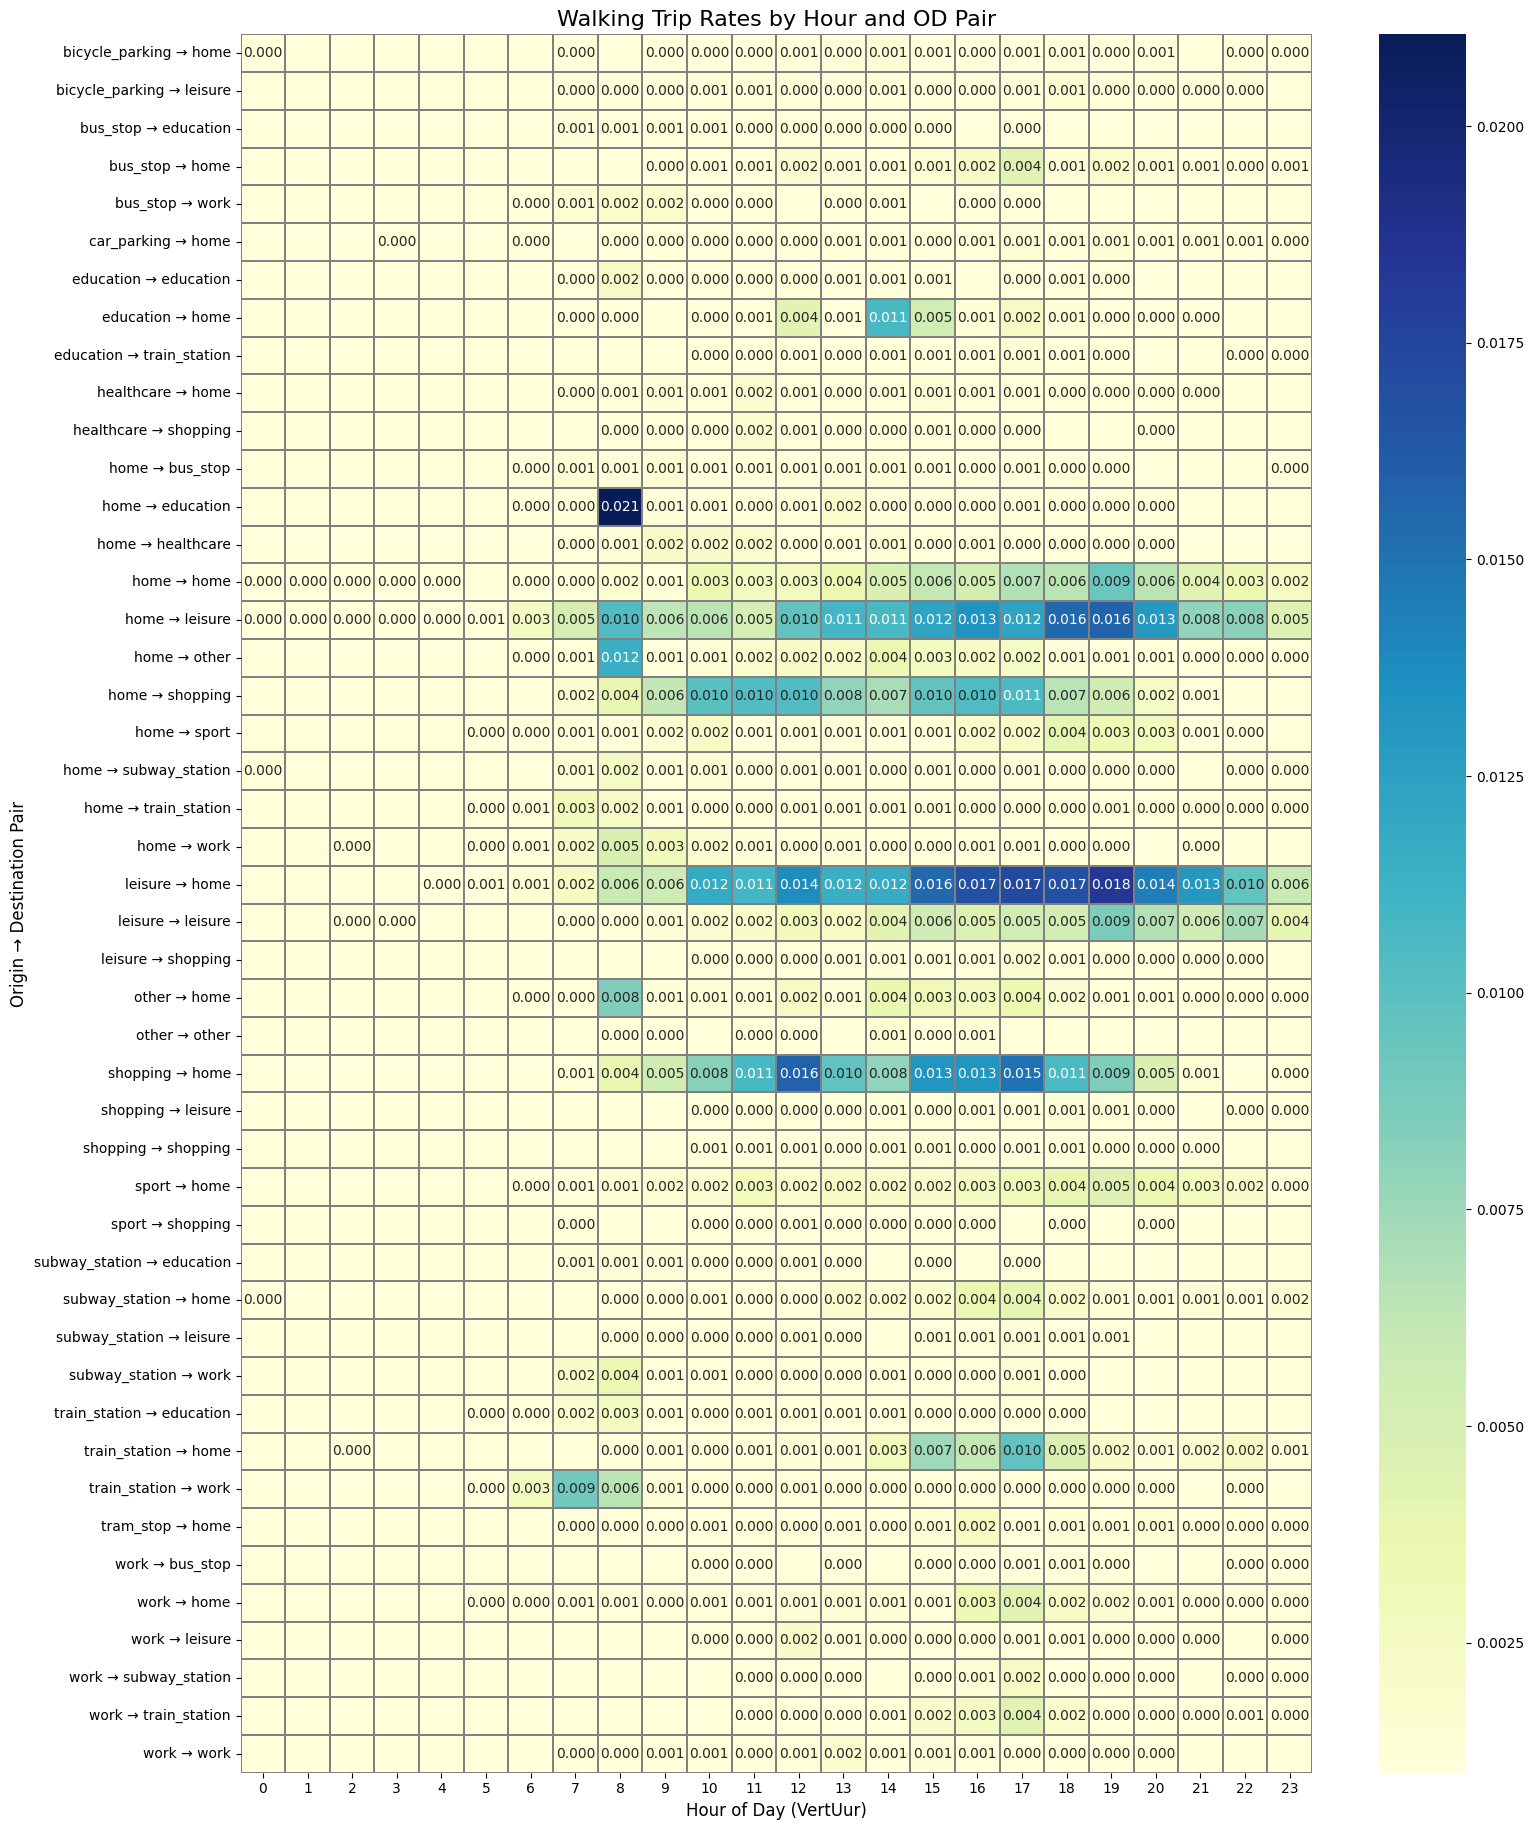

Saved: output/odin_trip_rates/patterns\heatmap_origin_type.png
Saved: output/odin_trip_rates/patterns\trip_rate_pattern_bicycle_parking.png
Saved: output/odin_trip_rates/patterns\trip_rate_pattern_bus_stop.png
Saved: output/odin_trip_rates/patterns\trip_rate_pattern_car_parking.png
Saved: output/odin_trip_rates/patterns\trip_rate_pattern_education.png
Saved: output/odin_trip_rates/patterns\trip_rate_pattern_healthcare.png
Saved: output/odin_trip_rates/patterns\trip_rate_pattern_home.png
Saved: output/odin_trip_rates/patterns\trip_rate_pattern_leisure.png
Saved: output/odin_trip_rates/patterns\trip_rate_pattern_other.png
Saved: output/odin_trip_rates/patterns\trip_rate_pattern_shopping.png
Saved: output/odin_trip_rates/patterns\trip_rate_pattern_sport.png
Saved: output/odin_trip_rates/patterns\trip_rate_pattern_subway_station.png
Saved: output/odin_trip_rates/patterns\trip_rate_pattern_train_station.png
Saved: output/odin_trip_rates/patterns\trip_rate_pattern_tram_stop.png
Saved: output

In [5]:
# CHECK THE DETERMINED TRIP RATES

# 1. load data and define the output folder
combined_trip_rates = pd.read_csv('output/odin_trip_rates/combined_trip_rates.csv')

patterns_dir = "output/odin_trip_rates/patterns"
os.makedirs(patterns_dir, exist_ok=True)

# 2. plot a heatmap of the trip rates bu OD pair and hour
heatmap_data = combined_trip_rates.pivot_table(
    index='OD_pair',
    columns='VertUur',
    values='trip_rate',
    fill_value=0
)

heatmap_data = heatmap_data[(heatmap_data > 0.001).any(axis=1)]
annot_data = heatmap_data.map(lambda x: f"{x:.3f}" if x > 0.000 else "")

plt.figure(figsize=(16, max(6, len(heatmap_data) * 0.4)))
sns.heatmap(
    heatmap_data,
    cmap="YlGnBu",
    linewidths=0.3,
    linecolor='gray',
    vmin=0.001,
    annot=annot_data,
    fmt=""
)
plt.title('Walking Trip Rates by Hour and OD Pair', fontsize=16)
plt.xlabel('Hour of Day (VertUur)', fontsize=12)
plt.ylabel('Origin → Destination Pair', fontsize=12)
plt.tight_layout()

heatmap1_path = os.path.join(patterns_dir, "heatmap_OD_pair.png")
plt.savefig(heatmap1_path, dpi=300)
print(f"Saved: {heatmap1_path}")

plt.show()

# 3. plot trip rates by origin type and VertUur
origin_hourly_trip_rates = (
    combined_trip_rates
    .groupby(['VertUur', 'origin'])['trip_rate']
    .sum()
    .reset_index()
)

heatmap_data_origin = origin_hourly_trip_rates.pivot_table(
    index='origin',
    columns='VertUur',
    values='trip_rate',
    fill_value=0
)

annot_data_origin = heatmap_data_origin.map(lambda x: f"{x:.3f}" if x > 0.000 else "")

plt.figure(figsize=(14, max(5, len(heatmap_data_origin) * 0.6)))
sns.heatmap(
    heatmap_data_origin,
    cmap="YlOrRd",
    linewidths=0.3,
    linecolor='gray',
    vmin=0,
    annot=annot_data_origin,
    fmt=""
)
plt.title('Total Walking Trip Rate by Origin Type and Hour of Day', fontsize=16)
plt.xlabel('Hour of Day (VertUur)', fontsize=12)
plt.ylabel('Origin Type', fontsize=12)
plt.tight_layout()

heatmap2_path = os.path.join(patterns_dir, "heatmap_origin_type.png")
plt.savefig(heatmap2_path, dpi=300)
plt.close()
print(f"Saved: {heatmap2_path}")

# 4. plot per origin type the trip rate for each destination type
origin_types = [
    "bicycle_parking", "bus_stop", "car_parking", "education", "healthcare",
    "home", "leisure", "other", "shopping", "sport",
    "subway_station", "train_station", "tram_stop", "work"
]
Y_MAX = 0.04

for origin in origin_types:
    subset = combined_trip_rates[combined_trip_rates["origin"] == origin]
    if subset.empty:
        print(f"No data for origin type: {origin}")
        continue

    pivot_data = subset.pivot_table(
        index="VertUur",
        columns="destination",
        values="trip_rate",
        aggfunc="sum",
        fill_value=0
    )

    plt.figure(figsize=(10, 6))
    for dest in pivot_data.columns:  # loop over all destinations
        plt.plot(pivot_data.index, pivot_data[dest], marker="o", label=dest)

    plt.title(f"Trip Rate Patterns from Origin: {origin}", fontsize=14)
    plt.xlabel("Hour of Day (VertUur)", fontsize=12)
    plt.ylabel("Trip Rate", fontsize=12)
    plt.ylim(0, Y_MAX)  # same scale for all plots
    plt.xticks(range(int(pivot_data.index.min()), int(pivot_data.index.max()) + 1))
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend(title="Destination", fontsize=8, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    # Save plot
    save_path = os.path.join(patterns_dir, f"trip_rate_pattern_{origin}.png")
    plt.savefig(save_path, dpi=300)
    plt.close()
    print(f"Saved: {save_path}")


In [ ]:
# DETERMINE THE GENERATED TRIPS FOR EACH NODE

#  Load inputs 
adjusted_weights = gpd.read_file(os.path.join("output", "network", "adjusted_weights.geojson")).to_crs(epsg=28992)
combined_trip_rates = pd.read_csv('output/odin_trip_rates/combined_trip_rates.csv')

# Quick duplicate-check in trip rates
dups = combined_trip_rates.duplicated(subset=['VertUur','origin','destination'], keep=False)
if dups.any():
    print("WARNING: duplicate rows in combined_trip_rates for same (VertUur, origin, destination):")
    print(combined_trip_rates[dups].sort_values(['VertUur','origin','destination']).head(10))
# Optionally collapse duplicates by summing trip_rate
combined_trip_rates = (combined_trip_rates
                       .groupby(['VertUur','origin','destination'], as_index=False)
                       .agg({'total_weighted_trips':'sum','trip_rate':'sum'}))

# Setup
output_dir = "output"
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, "generated_trips.csv")

# filter weights to Zuidas polygon (zuidas_poly must exist in scope)
weights_gdf = adjusted_weights.copy()
weights_gdf = weights_gdf.to_crs(epsg=28992)
weights_df = weights_gdf[weights_gdf.within(zuidas_poly)].reset_index(drop=True)

# identify candidate destination columns in the weights table (exclude metadata)
exclude_cols = {'origin_type','node_id','geometry','pandref'}
candidate_dest_cols = [c for c in weights_df.columns if c not in exclude_cols]

# force destination columns to numeric (coerce non-numeric → NaN → 0)
weights_df[candidate_dest_cols] = weights_df[candidate_dest_cols].apply(pd.to_numeric, errors='coerce').fillna(0)

# ensure trip rates numeric
combined_trip_rates['trip_rate'] = pd.to_numeric(combined_trip_rates['trip_rate'], errors='coerce').fillna(0)

# Build generated_df (long table)
results = []
for _, rr in combined_trip_rates.iterrows():
    hour = rr['VertUur']
    origin_type = rr['origin']
    dest_type = rr['destination']
    trip_rate = rr['trip_rate']

    # filter nodes of this origin_type
    matching_nodes = weights_df[weights_df['origin_type'] == origin_type]
    if matching_nodes.empty:
        continue
    if dest_type not in matching_nodes.columns:
        # destination not present in weights table
        continue

    gen = matching_nodes[['node_id', dest_type]].copy()
    gen = gen.rename(columns={dest_type: 'weight_dest'})
    # ensure numeric
    gen['weight_dest'] = pd.to_numeric(gen['weight_dest'], errors='coerce').fillna(0)
    gen['generated_trips'] = gen['weight_dest'] * float(trip_rate)
    gen = gen[['node_id', 'generated_trips']].copy()
    gen['VertUur'] = int(hour)
    gen['origin'] = origin_type
    gen['destination'] = dest_type

    results.append(gen)

if len(results) == 0:
    generated_df = pd.DataFrame(columns=['node_id','generated_trips','VertUur','origin','destination'])
else:
    generated_df = pd.concat(results, ignore_index=True)

# debug: duplicates in the long table
dup_count = generated_df.duplicated(subset=['node_id','VertUur','origin','destination']).sum()
print("generated_df rows:", len(generated_df), "duplicate OD rows:", dup_count)

# Pivot to wide format
generated_trips = generated_df.pivot_table(
    index=['node_id','VertUur','origin'],
    columns='destination',
    values='generated_trips',
    aggfunc='sum',
    fill_value=0
).reset_index()

# remove any empty column name leftover
generated_trips.columns.name = None

# Merge geometry / info (only the columns we need)
geometry_info = building_info[['node_id','geometry','pandref','centroid','nearest_edge_uvkey','nearest_point']].copy()
# Ensure node_id dtype matches
geometry_info['node_id'] = geometry_info['node_id'].astype(generated_trips['node_id'].dtype)

# merge and avoid creating duplicate columns by specifying suffixes
generated_trips = generated_trips.merge(geometry_info, on='node_id', how='left', suffixes=('','_info'))

# drop any accidental duplicate columns (safeguard)
generated_trips = generated_trips.loc[:, ~generated_trips.columns.duplicated()]

# Compute total_generated_trips robustly using numeric columns only 
numeric_cols = generated_trips.select_dtypes(include=[np.number]).columns.tolist()
# exclude node_id & VertUur from numeric sum
numeric_dest_cols = [c for c in numeric_cols if c not in ('node_id', 'VertUur')]

generated_trips['total_generated_trips'] = generated_trips[numeric_dest_cols].sum(axis=1, skipna=True)

# Save 
generated_trips.to_csv(output_path, index=False)
print("Saved generated_trips to:", output_path)


generated_df rows: 1240182 duplicate OD rows: 0
Saved generated_trips to: output\generated_trips.csv


In [106]:
# CHECK THE GENERATED TRIPS

generated_trips = pd.read_csv("output/generated_trips.csv")


# 1. print the generated trips
generated_trips.head()

# 2 check if trip rate x weight is done correctly
# Create a dictionary to lookup trip rates by (VertUur, origin, destination)
rate_lookup = combined_trip_rates.set_index(['VertUur', 'origin', 'destination'])['trip_rate'].to_dict()

# Flatten adjusted_weights for lookup
flat_weights_df = adjusted_weights.reset_index()

# Determine sample node_ids from start, middle, end
node_ids = generated_trips['node_id'].unique()
total_nodes = len(node_ids)

sample_node_ids = set()
sample_node_ids.update(node_ids[:3])                                # First 3
sample_node_ids.update(node_ids[total_nodes // 2 - 1: total_nodes // 2 + 2])  # Middle 3
sample_node_ids.update(node_ids[-3:])                               # Last 3

# Filter rows to just those sample node_ids
filtered_rows = generated_trips[generated_trips['node_id'].isin(sample_node_ids)]

# Loop through these specific rows
for idx, row in filtered_rows.iterrows():
    node_id = row['node_id']
    hour = row['VertUur']
    origin_type = row['origin']

    # Loop through destination columns (skip metadata columns)
    for dest_col in generated_trips.columns[3:]:
        actual_value = row[dest_col]
        if actual_value == 0:
            continue  # skip zero values

        key = (hour, origin_type, dest_col)
        if key not in rate_lookup:
            continue  # no trip rate defined

        trip_rate = rate_lookup[key]

        # Get adjusted weight for this node and destination
        node_row = flat_weights_df[flat_weights_df['node_id'] == node_id]
        if node_row.empty or dest_col not in node_row.columns:
            continue

        adjusted_weight = node_row.iloc[0][dest_col]
        expected = adjusted_weight * trip_rate
        diff = actual_value - expected

        # Print results
        print(f"NodeID: {node_id}, Hour: {hour}, Origin: {origin_type}, Destination: {dest_col}")
        print(f"  Adjusted Weight: {adjusted_weight:.8f}")
        print(f"  Trip Rate:       {trip_rate:.8f}")
        print(f"  Expected Trips:  {expected:.8f}")
        print(f"  Actual Trips:    {actual_value:.8f}")
        print(f"  Difference:      {diff:.8f}")
        print("-" * 60)


NodeID: 13077704300, Hour: 5, Origin: work, Destination: home
  Adjusted Weight: 226.43452824
  Trip Rate:       0.00013517
  Expected Trips:  0.03060810
  Actual Trips:    0.03060810
  Difference:      0.00000000
------------------------------------------------------------
NodeID: 13077704300, Hour: 6, Origin: work, Destination: home
  Adjusted Weight: 226.43452824
  Trip Rate:       0.00010620
  Expected Trips:  0.02404693
  Actual Trips:    0.02404693
  Difference:      -0.00000000
------------------------------------------------------------
NodeID: 13077704300, Hour: 7, Origin: work, Destination: home
  Adjusted Weight: 226.43452824
  Trip Rate:       0.00078636
  Expected Trips:  0.17805812
  Actual Trips:    0.17805812
  Difference:      0.00000000
------------------------------------------------------------
NodeID: 13077704300, Hour: 7, Origin: work, Destination: shopping
  Adjusted Weight: 639.78372792
  Trip Rate:       0.00012559
  Expected Trips:  0.08034777
  Actual Trips: 

In [ ]:
#CHECK THE GENERATED TRIPS VIA PLOTTING

# 2. plot for each origin type, for each VertUur the generated trips

# 2.1 setup
output_folder = "output/trip_generation_figures"
os.makedirs(output_folder, exist_ok=True)

pand = gpd.read_file(os.path.join("output", "building_data", "bag_panden.geojson")).to_crs(epsg=28992)  

place = ox.geocode_to_gdf("Zuidas, Amsterdam, Netherlands").to_crs(epsg=28992)
zuidas_poly = place.geometry.iloc[0]

generated_trips = pd.read_csv("output/generated_trips.csv")
generated_trips['geometry'] = generated_trips['geometry'].apply(wkt.loads)
generated_trips = gpd.GeoDataFrame(generated_trips, geometry='geometry', crs="EPSG:28992")

# GeoDataFrames
final_output_with_geo = gpd.GeoDataFrame(generated_trips, geometry='geometry', crs='EPSG:28992')
pand_base = gpd.GeoDataFrame(pand, geometry='geometry', crs='EPSG:28992')  # <- FIX

# Filter buildings to Zuidas
zuidas_poly = place.geometry.iloc[0]
pand_base_in_zuidas = pand_base[pand_base.within(zuidas_poly)].copy()

# Normalize building reference
final_output_with_geo['pandref_id'] = final_output_with_geo['pandref'].apply(
    lambda x: x[0] if isinstance(x, list) and x else None
)

# Only keep VBOs inside Zuidas buildings or standalone in Zuidas
valid_pand_ids = set(pand_base_in_zuidas['identificatie'])
final_output_with_geo = final_output_with_geo[
    final_output_with_geo['pandref_id'].isnull() |
    final_output_with_geo['pandref_id'].isin(valid_pand_ids)
].copy()

# Define target hours and origin types
hours = [7, 8, 9, 11, 12, 13, 16, 17, 18, 20, 21]
origin_types = final_output_with_geo['origin'].dropna().unique().tolist()

# Define point-only origin types (not linked to buildings)
point_origins = [
    'bicycle_parking', 'bus_stop', 'car_parking',
    'leisure', 'subway_station', 'train_station', 'tram_stop'
]

# 2.2 Generate plots
for origin in origin_types:
    for hour in hours:
        subset = final_output_with_geo[
            (final_output_with_geo['origin'] == origin) &
            (final_output_with_geo['VertUur'] == hour)
        ].copy()

        if subset.empty:
            continue

        # Plot as points (no aggregation) for point/combined origins
        if origin in point_origins or ',' in origin:
            # Filter points to Zuidas area
            subset = subset[subset.within(zuidas_poly)].copy()

            if subset.empty:
                continue
            
            fig, ax = plt.subplots(figsize=(10, 10))

            # Plot Zuidas base layer
            pand_base_in_zuidas.plot(ax=ax, color='lightgrey', edgecolor='black', linewidth=0.3)

            # Plot points
            subset.plot(ax=ax, color='red', markersize=40, edgecolor='black', alpha=0.8)

            # Add text labels for trip counts
            for _, row in subset.iterrows():
                if pd.notnull(row['total_generated_trips']):
                    try:
                        x, y = row.geometry.x, row.geometry.y
                        ax.text(x, y, str(int(round(row['total_generated_trips']))),
                                fontsize=6, ha='center', va='center', color='black')
                    except:
                        continue

            # Title & save
            ax.set_title(f"Trips in Zuidas — Origin: {origin} | Hour: {hour}", fontsize=12)
            ax.set_axis_off()
            plt.tight_layout()

            fname = f"{origin.replace(', ', '_').replace(' ', '_')}_VertUur_{hour}_points.png"
            plt.savefig(os.path.join(output_folder, fname), dpi=150, bbox_inches='tight')
            plt.close()

        # Otherwise: aggregate by building (as before)
        else:
            subset['pandref_id'] = subset['pandref']
            agg = (
                subset.groupby('pandref_id')['total_generated_trips']
                .sum()
                .reset_index()
            )

            merged = pand_base_in_zuidas.merge(
                agg,
                left_on='identificatie',
                right_on='pandref_id',
                how='left'
            )

            merged['total_generated_trips'] = merged['total_generated_trips'].fillna(0)
            merged = gpd.GeoDataFrame(merged, geometry='geometry', crs='EPSG:28992')

            fig, ax = plt.subplots(figsize=(10, 10))
            merged.plot(ax=ax, column='total_generated_trips', cmap='OrRd',
                        edgecolor='black', linewidth=0.3, legend=True)

            for _, row in merged.iterrows():
                if row['total_generated_trips'] > 0 and row['geometry'] is not None:
                    centroid = row['geometry'].centroid
                    try:
                        ax.text(
                            centroid.x, centroid.y,
                            str(int(round(row['total_generated_trips']))),
                            fontsize=6, ha='center', va='center', color='black'
                        )
                    except:
                        continue

            ax.set_title(f"Trip Generation in Zuidas\nOrigin: {origin} | Hour: {hour}", fontsize=12)
            ax.set_axis_off()
            plt.tight_layout()

            fname = f"{origin.replace(', ', '_').replace(' ', '_')}_VertUur_{hour}_aggregated.png"
            plt.savefig(os.path.join(output_folder, fname), dpi=150, bbox_inches='tight')
            plt.close()
